## Wavelet data generation..

In [1]:
def func(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('wavelets/train/'+cls)
  os.makedirs('wavelets/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [2]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Spectrogram generation..

In [3]:
import librosa
import matplotlib.pyplot as plt
import librosa.display


def func1(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('spectrogram/train/'+cls)
  os.makedirs('spectrogram/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [4]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)



['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Model training..

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf


import cv2
import os

import numpy as np

In [6]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data('spectrogram/train')
val = get_data('spectrogram/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_16136\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
# 現有的代碼：
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
# # 将训练和验证数据组合以用于交叉验证
# data = np.concatenate((x_train, x_val), axis=0)
# labels = np.concatenate((y_train, y_val), axis=0)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [11]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
history = model.fit(x_train,y_train,epochs = 500, validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 2/19 [==>...........................] - ETA: 12s - loss: 2.3632 - accuracy: 0.1719

KeyboardInterrupt: 

In [13]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history.history, open('history_500_epoch_simple.pkl','wb'))

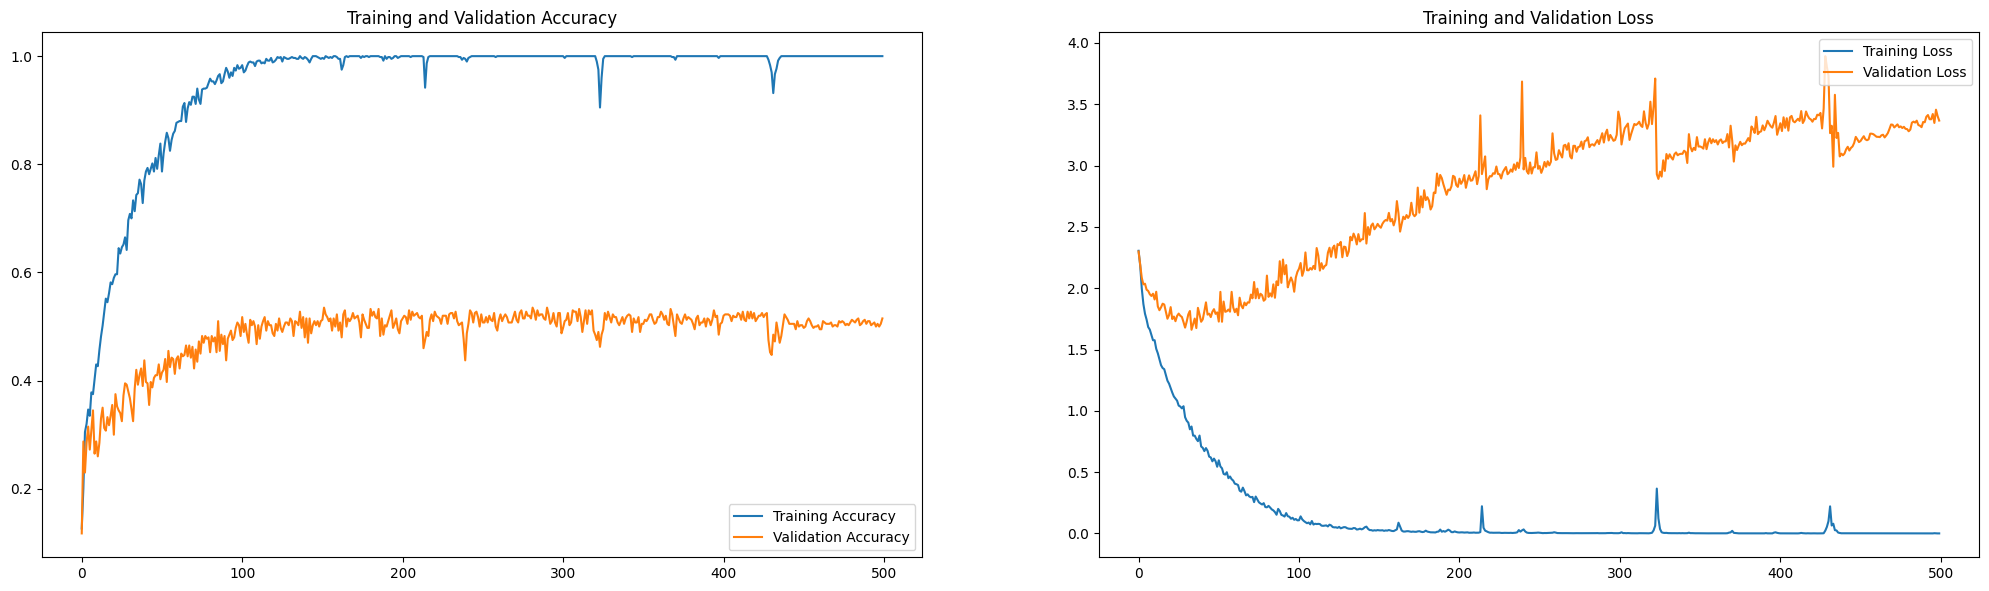

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
import pickle
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('sim_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [16]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 3s 181ms/step
              precision    recall  f1-score   support

       blues       0.48      0.50      0.49        40
   classical       0.91      0.80      0.85        40
     country       0.43      0.45      0.44        40
       disco       0.43      0.47      0.45        40
      hiphop       0.37      0.62      0.47        40
        jazz       0.56      0.45      0.50        40
       metal       0.72      0.72      0.73        40
         pop       0.79      0.57      0.67        40
      reggae       0.30      0.28      0.29        40
        rock       0.34      0.28      0.31        40

    accuracy                           0.52       400
   macro avg       0.53      0.52      0.52       400
weighted avg       0.53      0.52      0.52       400



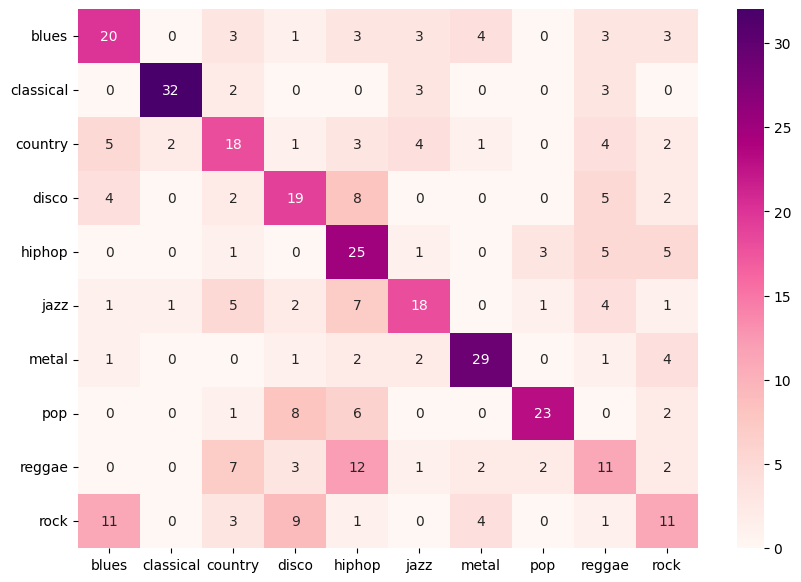

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

## Transfer Learning based modeling

### TL

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

In [11]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 22s 1s/step - loss: 2.1583 - accuracy: 0.2217 - val_loss: 1.9633 - val_accuracy: 0.2975
Epoch 2/500
19/19 [==============================] - 18s 956ms/step - loss: 1.6818 - accuracy: 0.4083 - val_loss: 1.8221 - val_accuracy: 0.2950
Epoch 3/500
19/19 [==============================] - 18s 992ms/step - loss: 1.4998 - accuracy: 0.4767 - val_loss: 1.7396 - val_accuracy: 0.3300
Epoch 4/500
19/19 [==============================] - 19s 1s/step - loss: 1.3938 - accuracy: 0.5150 - val_loss: 1.7002 - val_accuracy: 0.3350
Epoch 5/500
19/19 [==============================] - 16s 825ms/step - loss: 1.3303 - accuracy: 0.5183 - val_loss: 1.6659 - val_accuracy: 0.3725
Epoch 6/500
19/19 [==============================] - 14s 736ms/step - loss: 1.2559 - accuracy: 0.5333 - val_loss: 1.6316 - val_accuracy: 0.3900
Epoch 7/500
19/19 [==============================] - 15s 822ms/step - loss: 1.2064 - accuracy: 0.5717 - val_loss: 1.6011 - val_accuracy: 0.3775
Epoch 8/50

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
import pickle
model.save_weights('500_epoch_tr_lr.cpkt')

pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))

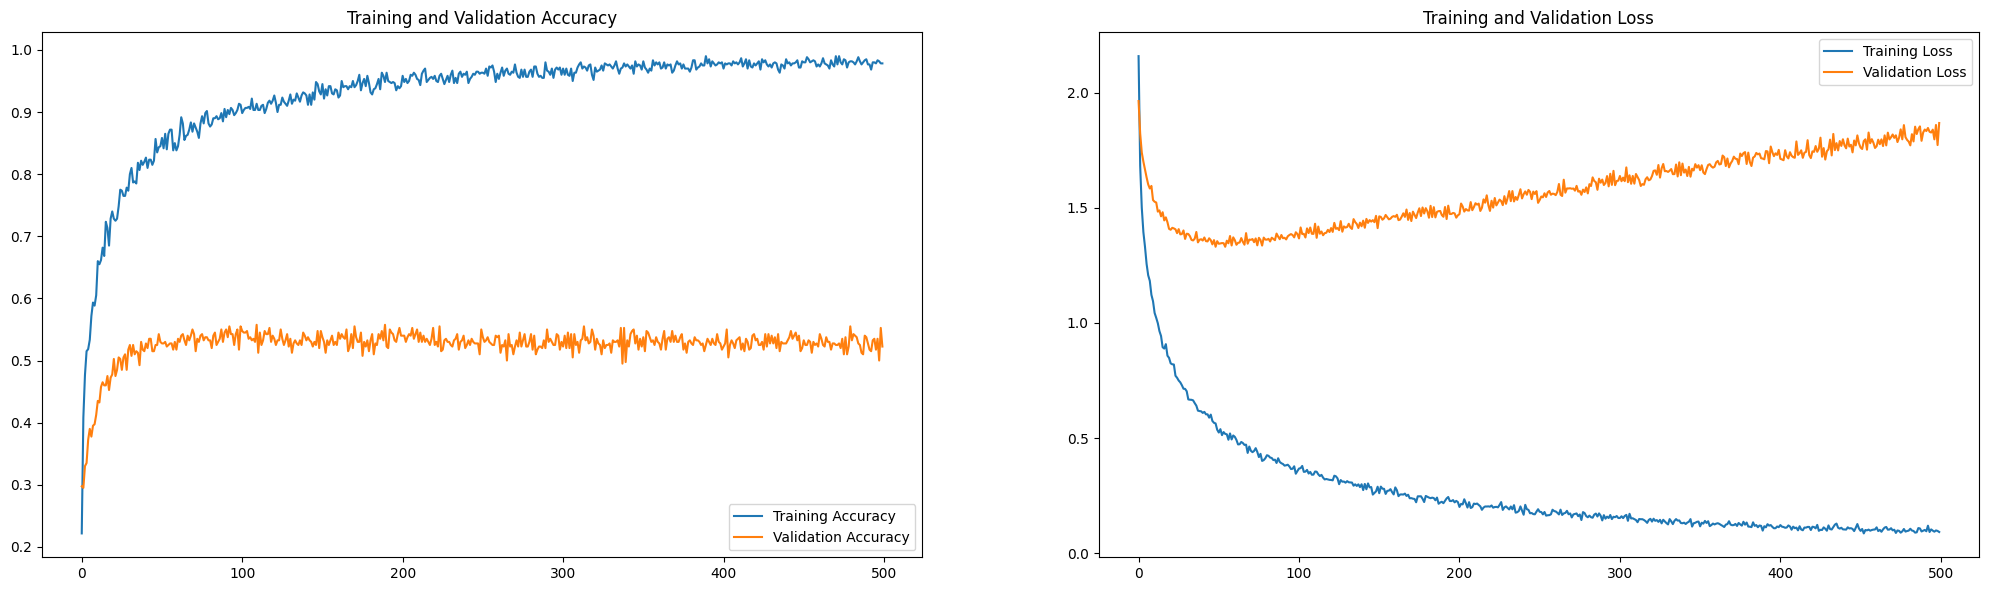

In [23]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
import pickle
history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [25]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 9s 560ms/step
              precision    recall  f1-score   support

       blues       0.42      0.62      0.50        40
   classical       0.91      0.75      0.82        40
     country       0.38      0.38      0.38        40
       disco       0.47      0.45      0.46        40
      hiphop       0.43      0.72      0.54        40
        jazz       0.69      0.55      0.61        40
       metal       0.69      0.55      0.61        40
         pop       0.84      0.65      0.73        40
      reggae       0.41      0.28      0.33        40
        rock       0.28      0.28      0.28        40

    accuracy                           0.52       400
   macro avg       0.55      0.52      0.53       400
weighted avg       0.55      0.52      0.53       400



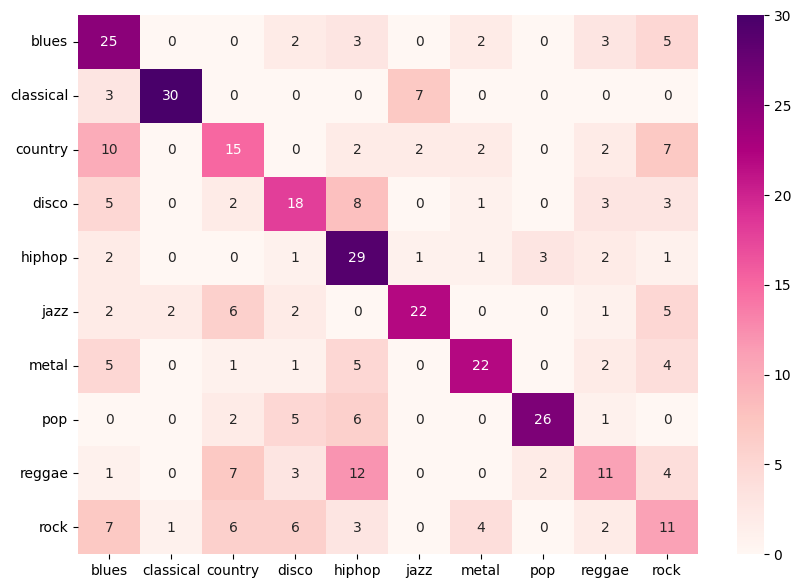

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [27]:
model.save_weights('500_epoch_transfer_lr.cpkt')
pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))


### TL_100

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
history21 = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

Epoch 1/100


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 33s 2s/step - loss: 2.2440 - accuracy: 0.2150 - val_loss: 2.0550 - val_accuracy: 0.2725
Epoch 2/100
19/19 [==============================] - 23s 1s/step - loss: 1.7530 - accuracy: 0.3917 - val_loss: 1.8371 - val_accuracy: 0.3300
Epoch 3/100
19/19 [==============================] - 21s 1s/step - loss: 1.5512 - accuracy: 0.4367 - val_loss: 1.7599 - val_accuracy: 0.3450
Epoch 4/100
19/19 [==============================] - 20s 1s/step - loss: 1.4066 - accuracy: 0.5117 - val_loss: 1.7097 - val_accuracy: 0.3775
Epoch 5/100
19/19 [==============================] - 21s 1s/step - loss: 1.3437 - accuracy: 0.5217 - val_loss: 1.6758 - val_accuracy: 0.3575
Epoch 6/100
19/19 [==============================] - 21s 1s/step - loss: 1.2760 - accuracy: 0.5467 - val_loss: 1.6399 - val_accuracy: 0.3725
Epoch 7/100
19/19 [==============================] - 21s 1s/step - loss: 1.2203 - accuracy: 0.5467 - val_loss: 1.6010 - val_accuracy: 0.4050
Epoch 8/100
19/19 [======

In [14]:
import pickle
model.save_weights('100_epoch_tr_lr.cpkt')

pickle.dump(history21.history, open('history_100_epoch_tr.pkl','wb'))

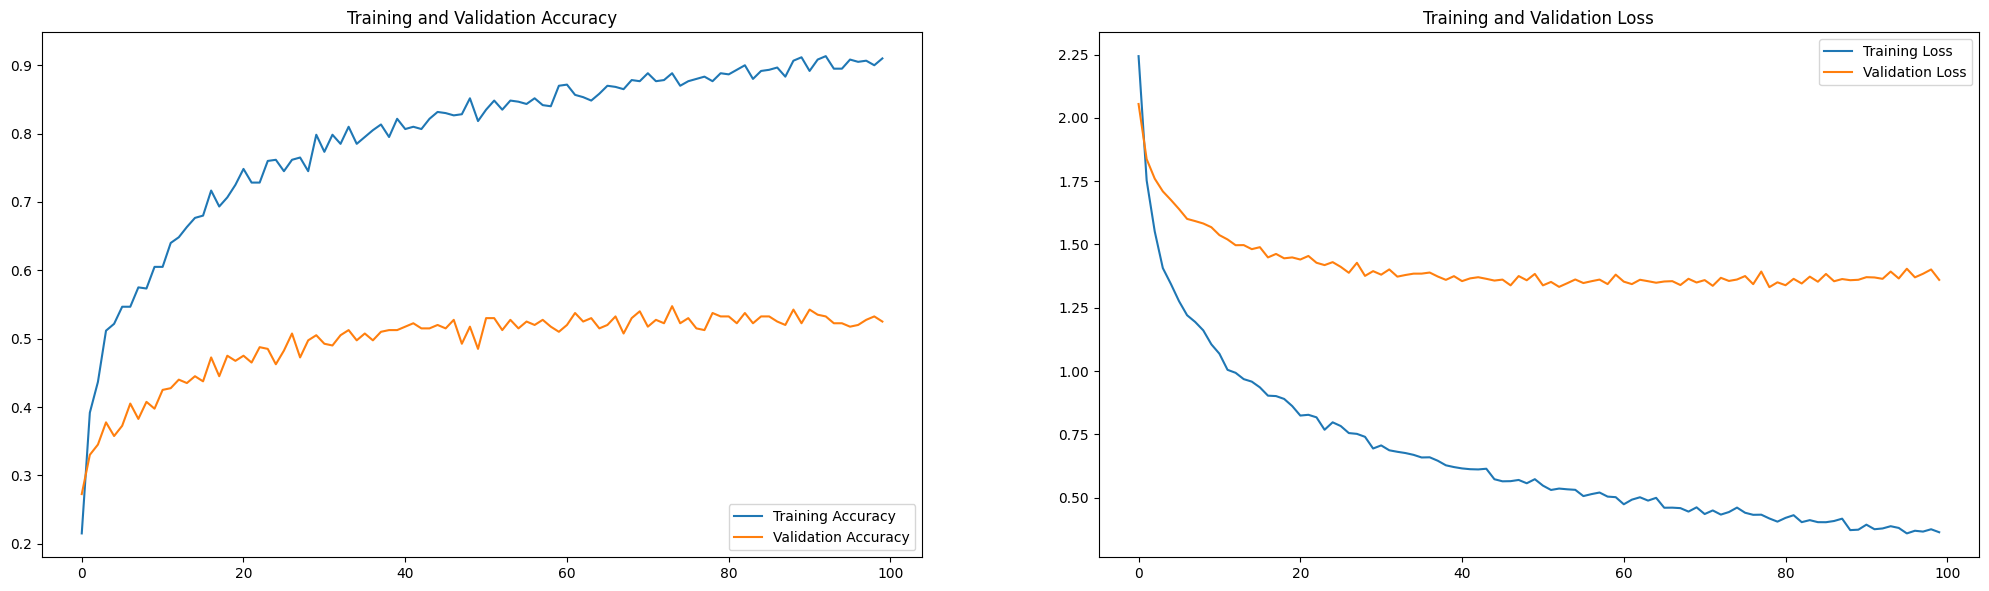

In [16]:
acc = history21.history['accuracy']
val_acc = history21.history['val_accuracy']
loss = history21.history['loss']
val_loss = history21.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import pickle
history = pickle.load(open('history_100_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

13/13 [==============================] - 8s 564ms/step
              precision    recall  f1-score   support

       blues       0.43      0.57      0.49        40
   classical       0.89      0.85      0.87        40
     country       0.39      0.33      0.36        40
       disco       0.42      0.38      0.39        40
      hiphop       0.49      0.62      0.55        40
        jazz       0.77      0.60      0.68        40
       metal       0.69      0.55      0.61        40
         pop       0.82      0.70      0.76        40
      reggae       0.36      0.35      0.35        40
        rock       0.23      0.30      0.26        40

    accuracy                           0.53       400
   macro avg       0.55      0.52      0.53       400
weighted avg       0.55      0.53      0.53       400



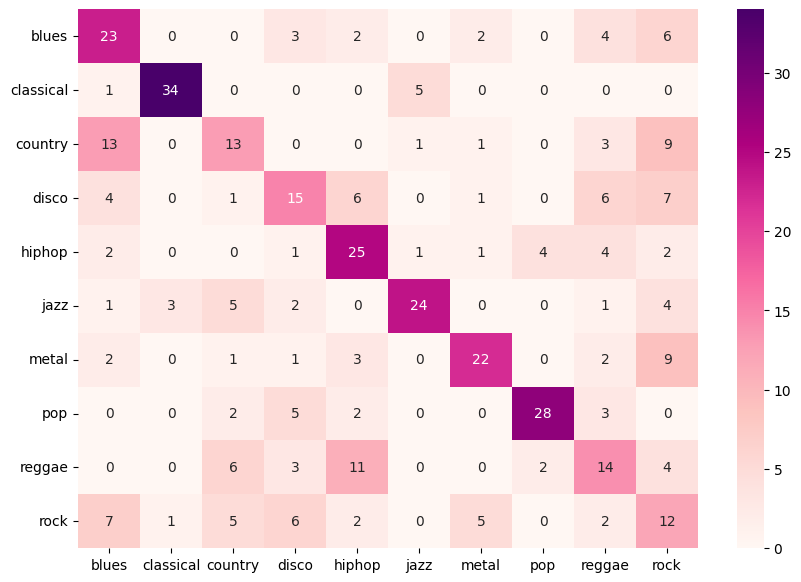

In [19]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx23.png',bbox_inches = 'tight')

## Multi-Model Training

In [28]:
sp_train = get_data('spectrogram/train')
sp_val = get_data('spectrogram/test')

wv_train = get_data('wavelets/train')
wv_val = get_data('wavelets/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_65512\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [29]:
x_sp_train = []
y_sp_train = []
x_sp_val = []
y_sp_val = []

for feature, label in sp_train:
  x_sp_train.append(feature)
  y_sp_train.append(label)

for feature, label in sp_val:
  x_sp_val.append(feature)
  y_sp_val.append(label)

# Normalize the data
x_sp_train = np.array(x_sp_train) / 255
x_sp_val = np.array(x_sp_val) / 255

x_sp_train.reshape(-1, img_size, img_size, 1)
y_sp_train = np.array(y_sp_train)

x_sp_val.reshape(-1, img_size, img_size, 1)
y_sp_val = np.array(y_sp_val)

In [30]:
x_wv_train = []
y_wv_train = []
x_wv_val = []
y_wv_val = []

for feature, label in wv_train:
  x_wv_train.append(feature)
  y_wv_train.append(label)

for feature, label in wv_val:
  x_wv_val.append(feature)
  y_wv_val.append(label)

# Normalize the data
x_wv_train = np.array(x_wv_train) / 255
x_wv_val = np.array(x_wv_val) / 255

x_wv_train.reshape(-1, img_size, img_size, 1)
y_wv_train = np.array(y_wv_train)

x_wv_val.reshape(-1, img_size, img_size, 1)
y_wv_val = np.array(y_wv_val)

In [31]:
datagen_sp = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_sp.fit(x_sp_train)

datagen_wv = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_wv.fit(x_wv_train)

In [32]:
input_sp = keras.Input(shape=(256,256,3))
input_wv = keras.Input(shape=(256,256,3))

x = Conv2D(32,3,padding="same", activation="relu")(input_sp)
x = MaxPool2D()(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPool2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128,activation="relu")(x)
x = keras.Model(inputs=input_sp, outputs=x)

y = Conv2D(32,3,padding="same", activation="relu")(input_wv)
y = MaxPool2D()(y)
y = Conv2D(64, 3, padding="same", activation="relu")(y)
y = MaxPool2D()(y)
y = Dropout(0.4)(y)
y = Flatten()(y)
y = Dense(128,activation="relu")(y)
y = keras.Model(inputs=input_wv, outputs=y)

from tensorflow.keras.layers import concatenate
combined = concatenate([x.output, y.output])

z = Dense(32, activation="relu")(combined)
z = Dense(10, activation="softmax")(z)

model = keras.Model(inputs=[x.input, y.input], outputs=z)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                           

In [34]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
history2 = model.fit([x_sp_train,x_wv_train],y_sp_train,epochs = 500, validation_data = ([x_sp_val,x_wv_val], y_sp_val))
import pickle
model.save_weights('500_epoch_multi_lr.cpkt')
pickle.dump(history2.history, open('history_500_epoch_multi.pkl','wb'))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 38s 2s/step - loss: 2.4228 - accuracy: 0.1117 - val_loss: 2.3050 - val_accuracy: 0.1250
Epoch 2/500
19/19 [==============================] - 34s 2s/step - loss: 2.2980 - accuracy: 0.1067 - val_loss: 2.3036 - val_accuracy: 0.0400
Epoch 3/500
19/19 [==============================] - 35s 2s/step - loss: 2.2773 - accuracy: 0.1400 - val_loss: 2.2484 - val_accuracy: 0.1050
Epoch 4/500
19/19 [==============================] - 29s 2s/step - loss: 2.2240 - accuracy: 0.1533 - val_loss: 2.2065 - val_accuracy: 0.1875
Epoch 5/500
19/19 [==============================] - 29s 2s/step - loss: 2.1963 - accuracy: 0.1733 - val_loss: 2.2460 - val_accuracy: 0.1325
Epoch 6/500
19/19 [==============================] - 29s 2s/step - loss: 2.1557 - accuracy: 0.1817 - val_loss: 2.1815 - val_accuracy: 0.1500
Epoch 7/500
19/19 [==============================] - 28s 1s/step - loss: 2.1327 - accuracy: 0.2083 - val_loss: 2.2178 - val_accuracy: 0.1675
Epoch 8/500
19/19 [======

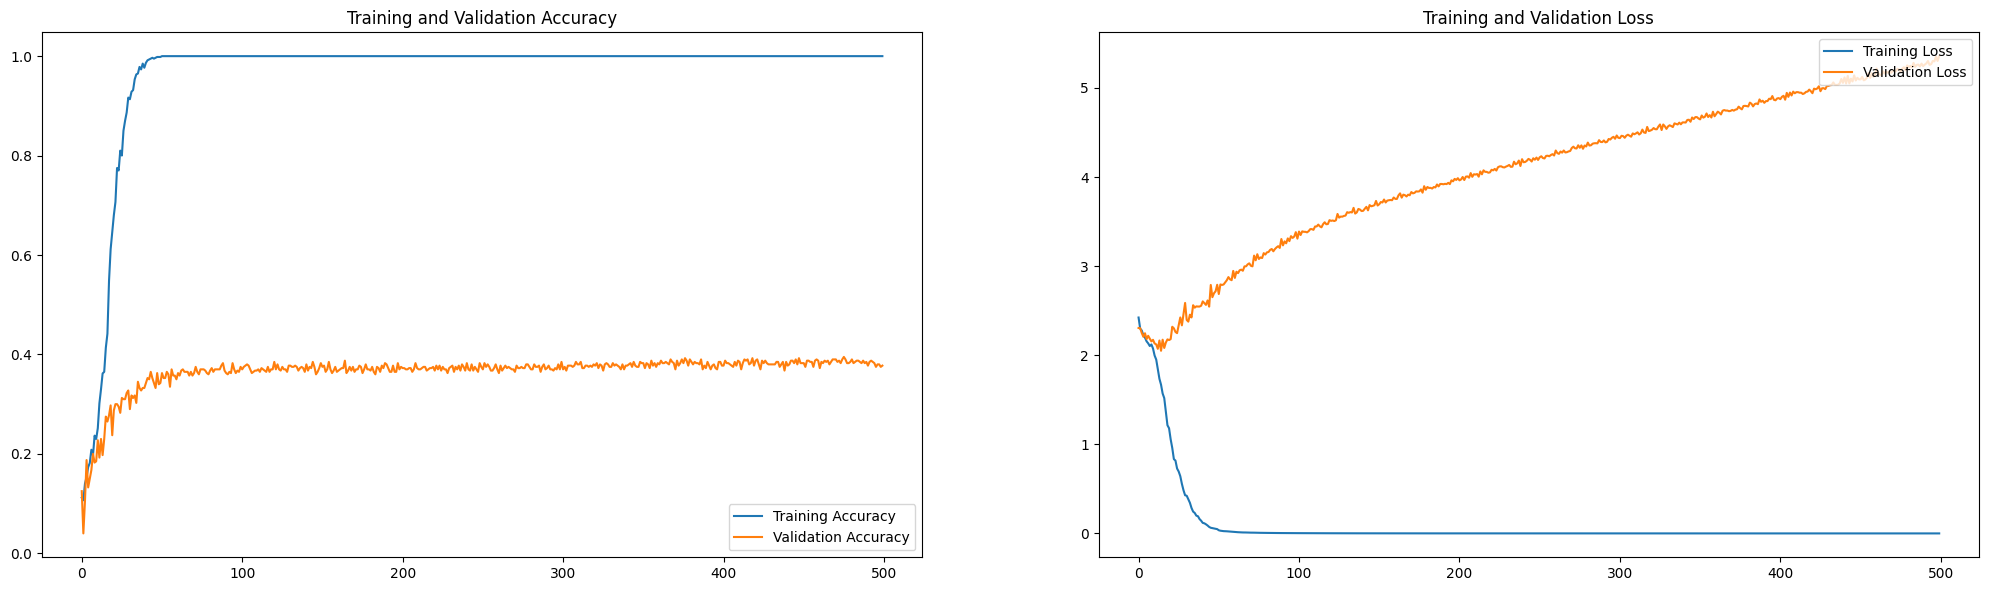

In [36]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
import pickle
history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('multi_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [38]:
predictions = model.predict([x_sp_val,x_wv_val])
print(classification_report(y_wv_val, np.argmax(predictions, axis=1), target_names = labels))

13/13 [==============================] - 6s 448ms/step
              precision    recall  f1-score   support

       blues       0.19      0.23      0.21        40
   classical       0.80      0.60      0.69        40
     country       0.16      0.12      0.14        40
       disco       0.43      0.33      0.37        40
      hiphop       0.29      0.45      0.35        40
        jazz       0.31      0.33      0.32        40
       metal       0.48      0.57      0.52        40
         pop       0.71      0.72      0.72        40
      reggae       0.33      0.33      0.33        40
        rock       0.14      0.10      0.12        40

    accuracy                           0.38       400
   macro avg       0.38      0.38      0.38       400
weighted avg       0.38      0.38      0.38       400



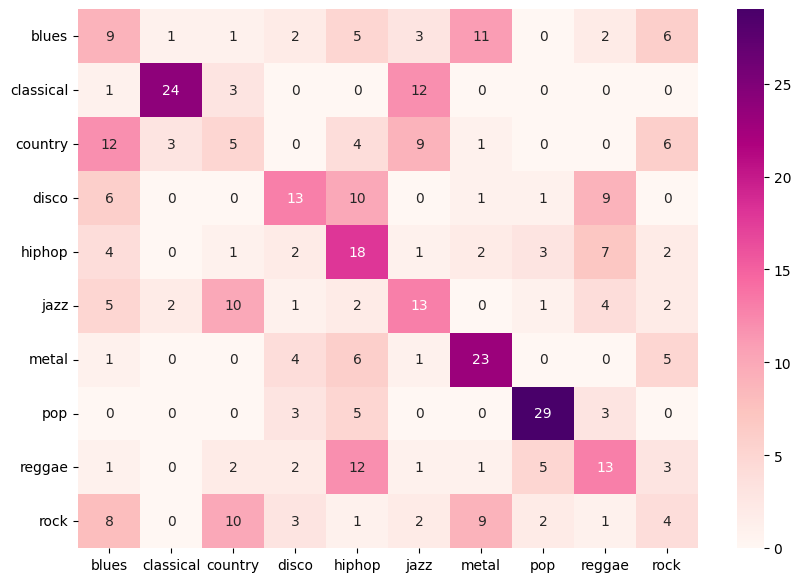

In [39]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
predictions = np.argmax(predictions, axis=1)
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')

In [43]:
epochs_range = range(500)
import matplotlib.pyplot as plt
import pickle 
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc1 = history['accuracy']
val_acc1 = history['val_accuracy']
loss1 = history['loss']
val_loss1 = history['val_loss']

history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc2 = history['accuracy']
val_acc2 = history['val_accuracy']
loss2 = history['loss']
val_loss2 = history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot(epochs_range, acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot(epochs_range, val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)
ax1.plot(epochs_range, acc2, label='Multi modal Training Accuracy', c = '#171c1c', linewidth=4)
ax1.plot(epochs_range, val_acc2, label='Multi modal Validation Accuracy', c='#62176e', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot(epochs_range, loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot(epochs_range, val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)
ax2.plot(epochs_range, loss2, label='Multi modal Training Loss',c = '#171c1c', linewidth=4)
ax2.plot(epochs_range, val_loss2, label='Multi modal learning Validation Loss', c='#62176e', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('all_1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

## Transfer learning+BILSTM

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [11]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [12]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(lstm_input)  # 使用Bidirectional LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          7344128   
 l)                                                              
                                                             

In [19]:
history3 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [18]:
import pickle
model.save_weights('500_epoch_tr_BILSTM.cpkt')

pickle.dump(history3.history, open('history_500_epoch_tr_BILSTM.pkl','wb'))

NameError: name 'history3' is not defined

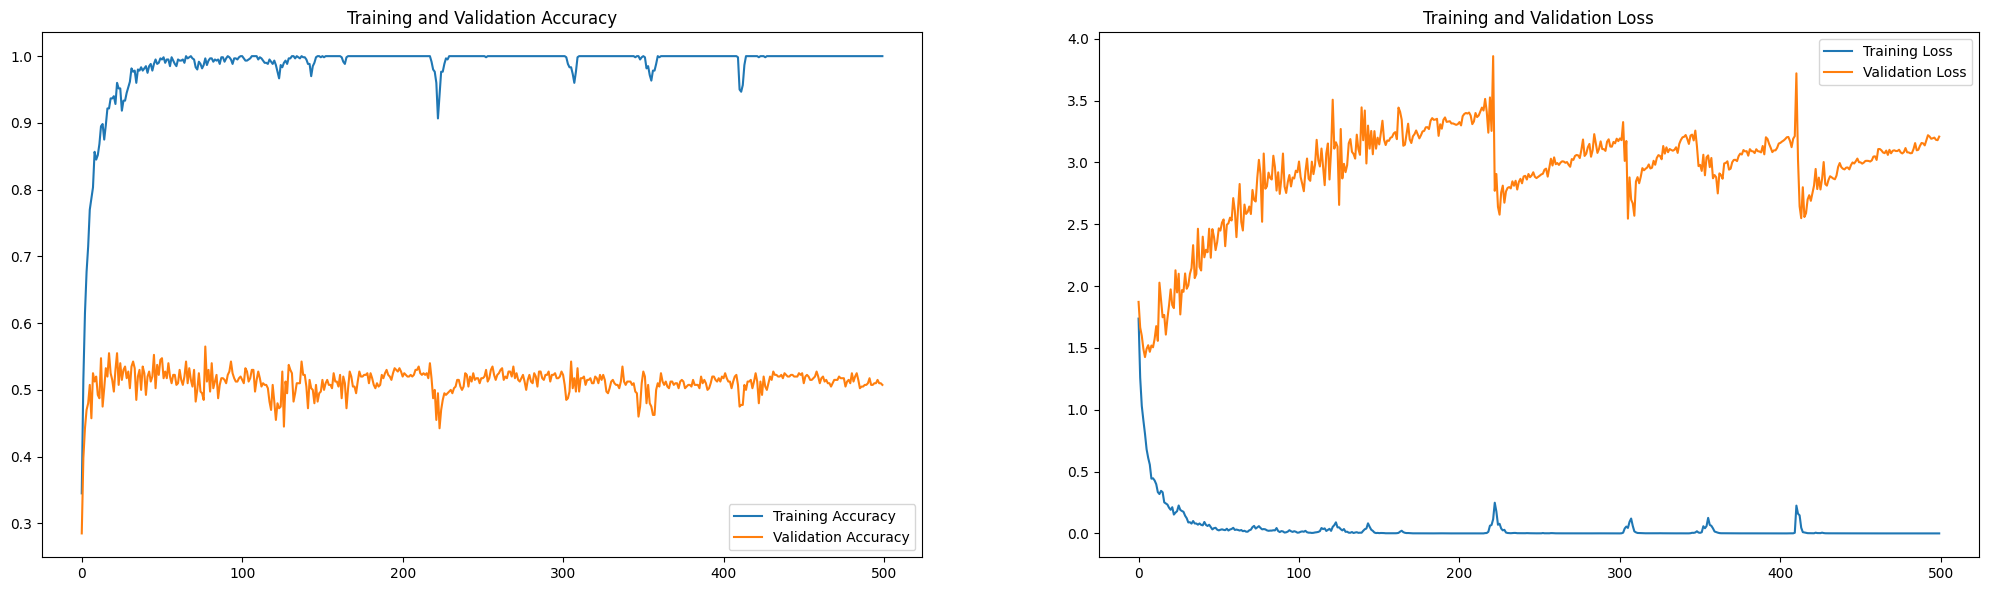

In [19]:
import pickle
history3 = pickle.load(open('history_500_epoch_tr_BILSTM.pkl','rb'))
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
import pickle
history = pickle.load(open('history_500_epoch_tr_BILSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_BILSTM_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [28]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 6s 435ms/step


In [29]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [30]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.46      0.55      0.50        40
   classical       0.83      0.85      0.84        40
     country       0.40      0.42      0.41        40
       disco       0.40      0.47      0.44        40
      hiphop       0.40      0.65      0.50        40
        jazz       0.76      0.55      0.64        40
       metal       0.72      0.57      0.64        40
         pop       0.76      0.65      0.70        40
      reggae       0.26      0.23      0.24        40
        rock       0.18      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.52      0.51      0.51       400
weighted avg       0.52      0.51      0.51       400



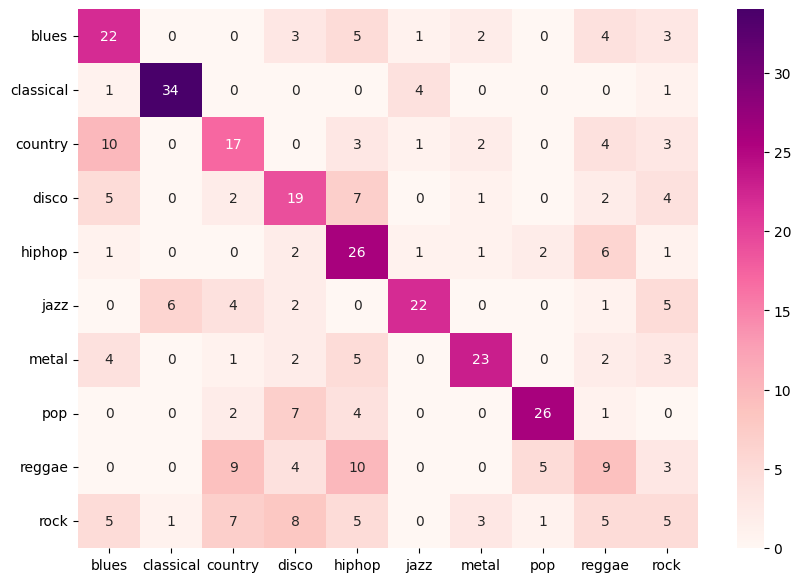

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx4.png',bbox_inches = 'tight')

## Transfer learning+LSTM

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(lstm_input) # 使用LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3672064   
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [16]:
history4 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 21s 929ms/step - loss: 1.8044 - accuracy: 0.3617 - val_loss: 1.7532 - val_accuracy: 0.3375
Epoch 2/500
19/19 [==============================] - 14s 769ms/step - loss: 1.3266 - accuracy: 0.5167 - val_loss: 1.7916 - val_accuracy: 0.3575
Epoch 3/500
19/19 [==============================] - 13s 706ms/step - loss: 1.1801 - accuracy: 0.5500 - val_loss: 1.5943 - val_accuracy: 0.4275
Epoch 4/500
19/19 [==============================] - 13s 715ms/step - loss: 1.0027 - accuracy: 0.6450 - val_loss: 1.5112 - val_accuracy: 0.4750
Epoch 5/500
19/19 [==============================] - 13s 699ms/step - loss: 0.8514 - accuracy: 0.6883 - val_loss: 1.4471 - val_accuracy: 0.4675
Epoch 6/500
19/19 [==============================] - 13s 701ms/step - loss: 0.8305 - accuracy: 0.7050 - val_loss: 1.5454 - val_accuracy: 0.4350
Epoch 7/500
19/19 [==============================] - 17s 919ms/step - loss: 0.7630 - accuracy: 0.7383 - val_loss: 1.4237 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_LSTM.cpkt')

pickle.dump(history4.history, open('history_500_epoch_tr_LSTM.pkl','wb'))

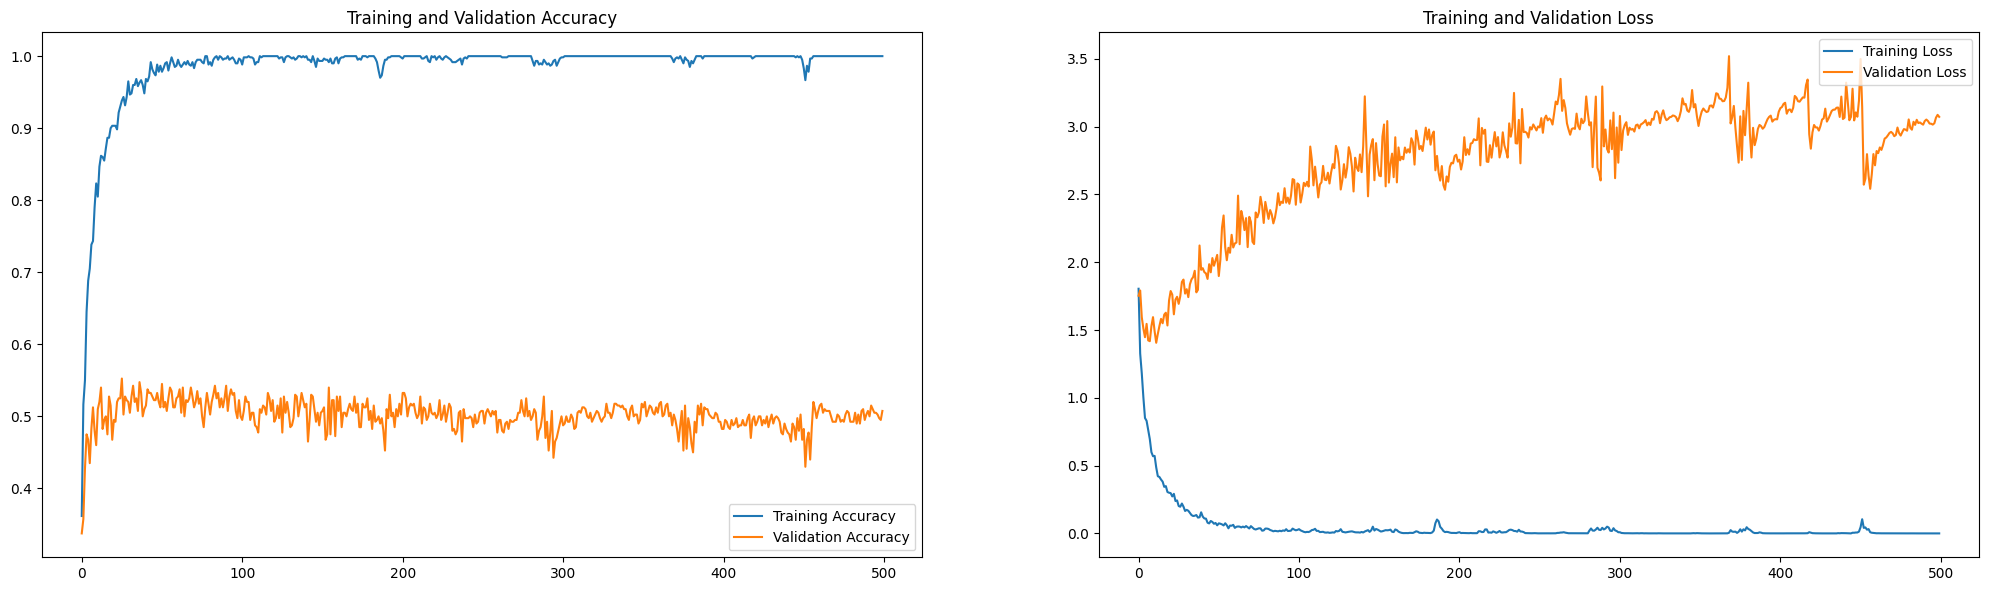

In [18]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_LSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_LSTM_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 7s 446ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.47      0.55      0.51        40
   classical       0.83      0.88      0.85        40
     country       0.39      0.35      0.37        40
       disco       0.45      0.50      0.48        40
      hiphop       0.39      0.68      0.49        40
        jazz       0.70      0.47      0.57        40
       metal       0.69      0.68      0.68        40
         pop       0.78      0.62      0.69        40
      reggae       0.26      0.25      0.26        40
        rock       0.16      0.10      0.12        40

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400



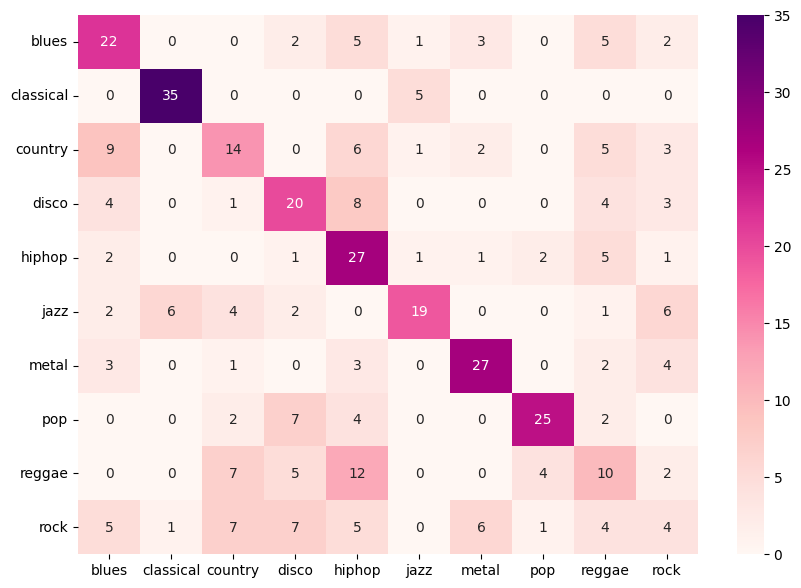

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx5.png',bbox_inches = 'tight')

## Transfer learning+RNN

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False


In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
rnn_layer = keras.layers.SimpleRNN(512, return_sequences=True, dropout=0.2)(lstm_input) # 使用RNN處理特徵序列
rnn_output = Flatten()(rnn_layer)  # 將RNN輸出扁平化
output = Dense(10, activation='softmax')(rnn_output) # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 512)            918016    
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [16]:
history5 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 20s 914ms/step - loss: 1.9860 - accuracy: 0.3417 - val_loss: 1.9849 - val_accuracy: 0.3300
Epoch 2/500
19/19 [==============================] - 14s 777ms/step - loss: 1.3688 - accuracy: 0.5050 - val_loss: 1.7107 - val_accuracy: 0.3875
Epoch 3/500
19/19 [==============================] - 14s 740ms/step - loss: 1.1389 - accuracy: 0.5817 - val_loss: 1.6460 - val_accuracy: 0.4200
Epoch 4/500
19/19 [==============================] - 14s 748ms/step - loss: 0.9950 - accuracy: 0.6400 - val_loss: 1.4558 - val_accuracy: 0.4700
Epoch 5/500
19/19 [==============================] - 14s 737ms/step - loss: 0.9609 - accuracy: 0.6483 - val_loss: 1.7588 - val_accuracy: 0.4300
Epoch 6/500
19/19 [==============================] - 14s 745ms/step - loss: 0.8822 - accuracy: 0.6917 - val_loss: 1.5641 - val_accuracy: 0.4575
Epoch 7/500
19/19 [==============================] - 14s 776ms/step - loss: 0.7674 - accuracy: 0.7200 - val_loss: 1.4306 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_RNN.cpkt')

pickle.dump(history5.history, open('history_500_epoch_tr_RNN.pkl','wb'))

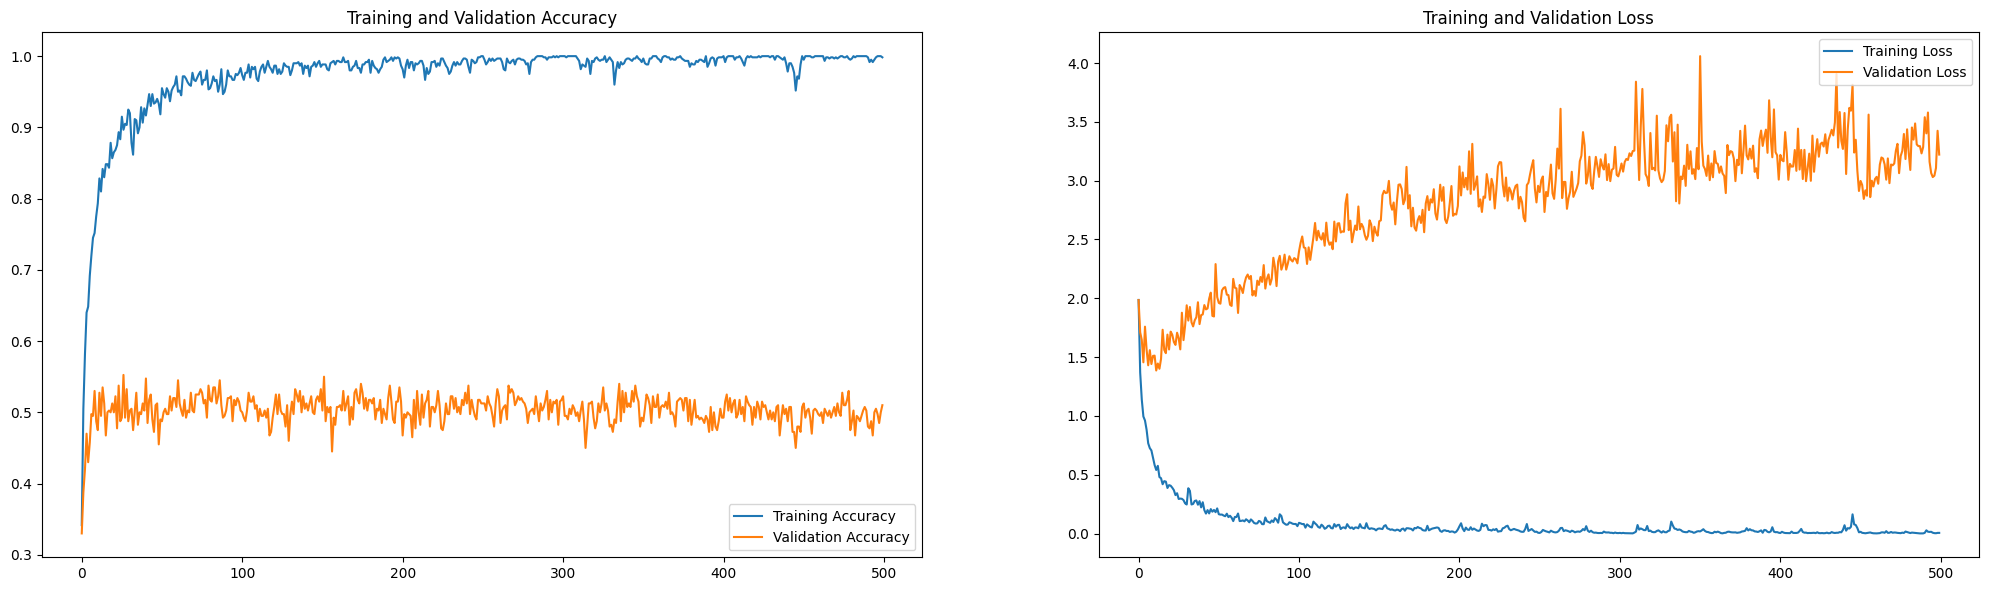

In [18]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_RNN.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_RNN_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 7s 440ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.39      0.53      0.45        40
   classical       0.89      0.78      0.83        40
     country       0.47      0.40      0.43        40
       disco       0.51      0.45      0.48        40
      hiphop       0.41      0.70      0.52        40
        jazz       0.66      0.57      0.61        40
       metal       0.79      0.47      0.59        40
         pop       0.74      0.65      0.69        40
      reggae       0.30      0.25      0.27        40
        rock       0.26      0.30      0.28        40

    accuracy                           0.51       400
   macro avg       0.54      0.51      0.52       400
weighted avg       0.54      0.51      0.52       400



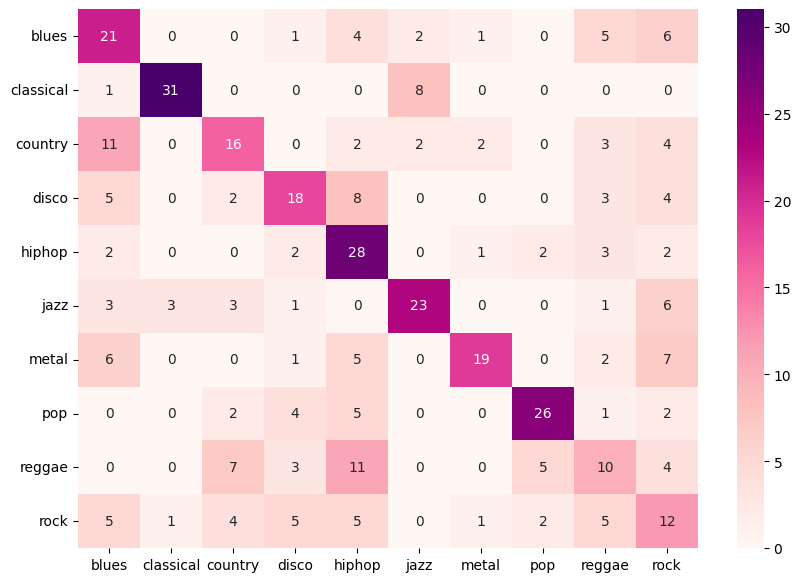

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx6.png',bbox_inches = 'tight')

## Transfer learning+GRU

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

In [16]:
history6 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 22s 904ms/step - loss: 1.8814 - accuracy: 0.3500 - val_loss: 1.8030 - val_accuracy: 0.2900
Epoch 2/500
19/19 [==============================] - 15s 823ms/step - loss: 1.2396 - accuracy: 0.5400 - val_loss: 1.6514 - val_accuracy: 0.3925
Epoch 3/500
19/19 [==============================] - 15s 790ms/step - loss: 1.0504 - accuracy: 0.6067 - val_loss: 1.5188 - val_accuracy: 0.4150
Epoch 4/500
19/19 [==============================] - 15s 809ms/step - loss: 0.9161 - accuracy: 0.6667 - val_loss: 1.3986 - val_accuracy: 0.4900
Epoch 5/500
19/19 [==============================] - 15s 794ms/step - loss: 0.7776 - accuracy: 0.7250 - val_loss: 1.5104 - val_accuracy: 0.4700
Epoch 6/500
19/19 [==============================] - 15s 800ms/step - loss: 0.7492 - accuracy: 0.7317 - val_loss: 1.6145 - val_accuracy: 0.4425
Epoch 7/500
19/19 [==============================] - 16s 845ms/step - loss: 0.6958 - accuracy: 0.7550 - val_loss: 1.7399 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_GRU.cpkt')

pickle.dump(history6.history, open('history_500_epoch_tr_GRU.pkl','wb'))

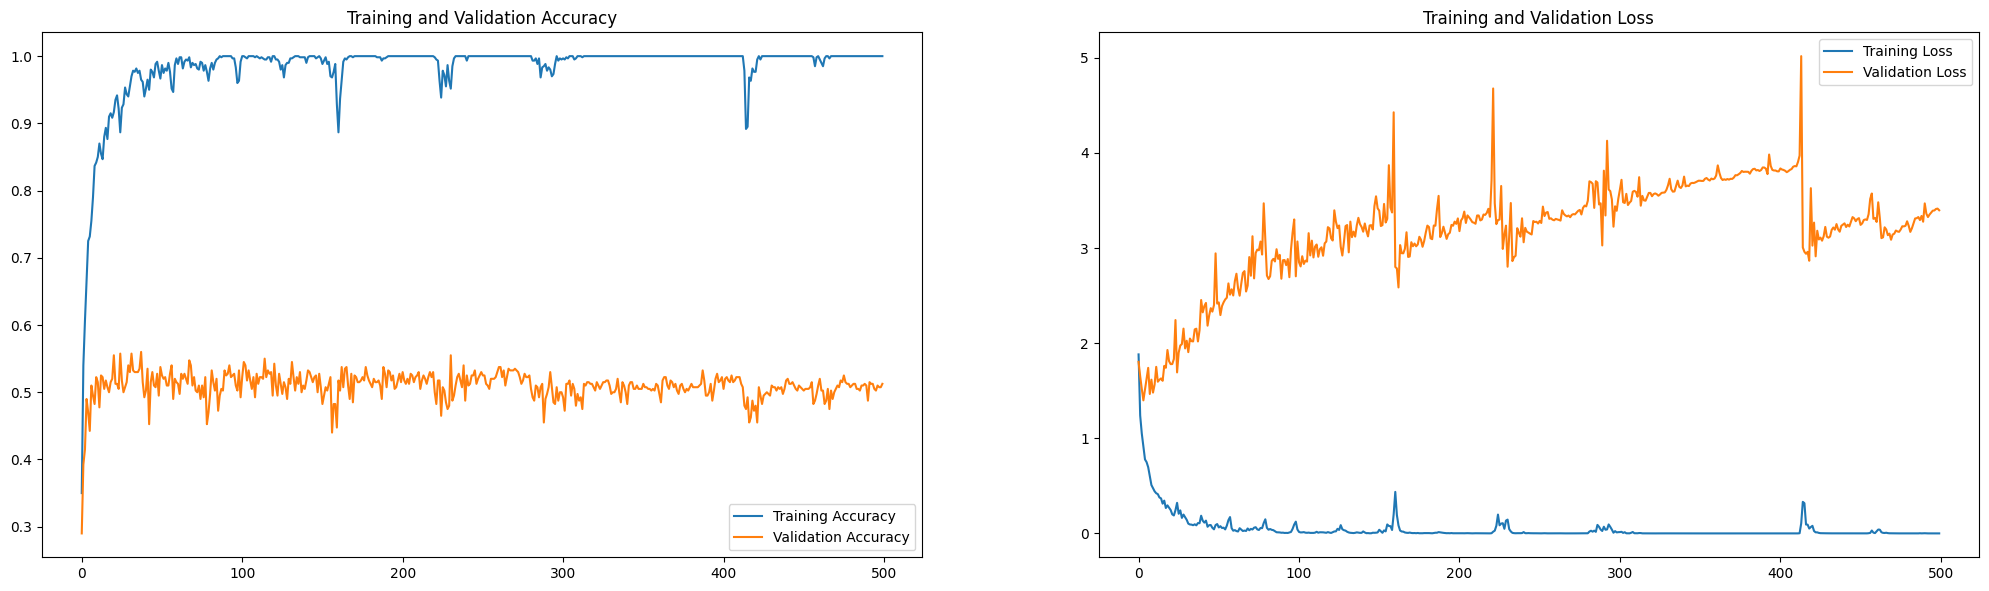

In [18]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_GRU.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_GRU_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 11s 701ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.46      0.57      0.51        40
   classical       0.85      0.85      0.85        40
     country       0.39      0.42      0.40        40
       disco       0.43      0.53      0.47        40
      hiphop       0.43      0.62      0.51        40
        jazz       0.75      0.60      0.67        40
       metal       0.69      0.55      0.61        40
         pop       0.74      0.62      0.68        40
      reggae       0.25      0.23      0.24        40
        rock       0.20      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.52      0.51      0.51       400
weighted avg       0.52      0.51      0.51       400



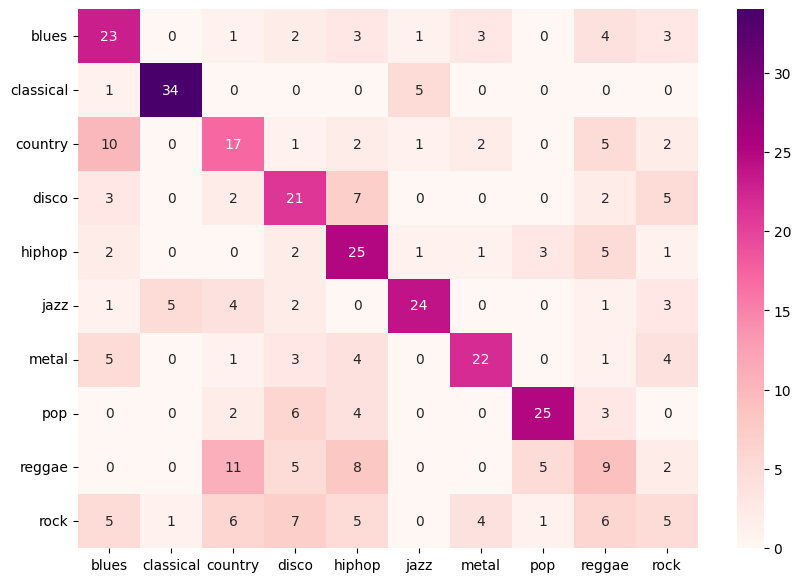

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx7.png',bbox_inches = 'tight')

## TL+BiLSTM2(多跑datagen)

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator


In [11]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")


In [12]:
mobilenetv2.trainable = False

In [13]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(lstm_input)  # 使用Bidirectional LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別

In [14]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [15]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [16]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          7344128   
 l)                                                              
                                                             

In [17]:
history7 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500)


Epoch 1/500
19/19 [==============================] - 22s 925ms/step - loss: 1.8051 - accuracy: 0.3417 - val_loss: 1.7841 - val_accuracy: 0.3375
Epoch 2/500
19/19 [==============================] - 15s 798ms/step - loss: 1.2934 - accuracy: 0.5217 - val_loss: 1.7628 - val_accuracy: 0.3775
Epoch 3/500
19/19 [==============================] - 15s 798ms/step - loss: 1.0798 - accuracy: 0.6067 - val_loss: 1.4562 - val_accuracy: 0.4425
Epoch 4/500
19/19 [==============================] - 15s 788ms/step - loss: 0.8715 - accuracy: 0.7033 - val_loss: 1.3926 - val_accuracy: 0.5025
Epoch 5/500
19/19 [==============================] - 15s 799ms/step - loss: 0.8054 - accuracy: 0.7100 - val_loss: 1.4303 - val_accuracy: 0.4900
Epoch 6/500
19/19 [==============================] - 15s 795ms/step - loss: 0.7055 - accuracy: 0.7600 - val_loss: 1.4853 - val_accuracy: 0.4675
Epoch 7/500
19/19 [==============================] - 15s 786ms/step - loss: 0.6159 - accuracy: 0.7850 - val_loss: 1.4196 - val_accuracy:

In [18]:
import pickle
model.save_weights('500_epoch_tr_BiLSTM2.cpkt')

pickle.dump(history7.history, open('history_500_epoch_tr_BiLSTM2.pkl','wb'))

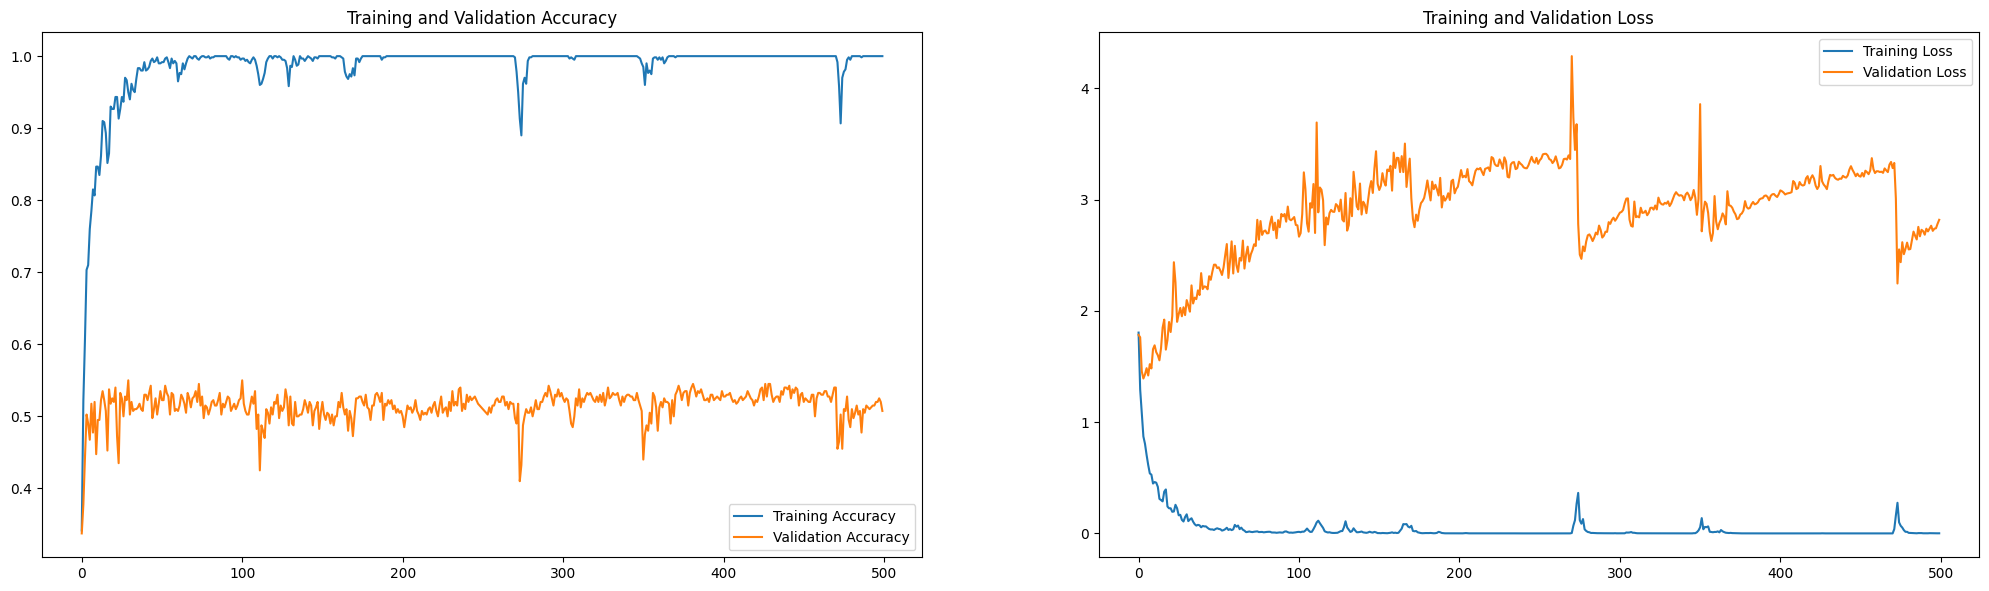

In [19]:

acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
import pickle
history = pickle.load(open('history_500_epoch_tr_BiLSTM2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_BiLSTM2_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [22]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 9s 612ms/step


In [23]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [24]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.47      0.53      0.49        40
   classical       0.87      0.85      0.86        40
     country       0.35      0.33      0.34        40
       disco       0.45      0.47      0.46        40
      hiphop       0.41      0.70      0.51        40
        jazz       0.73      0.55      0.63        40
       metal       0.60      0.70      0.64        40
         pop       0.79      0.57      0.67        40
      reggae       0.29      0.25      0.27        40
        rock       0.19      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400



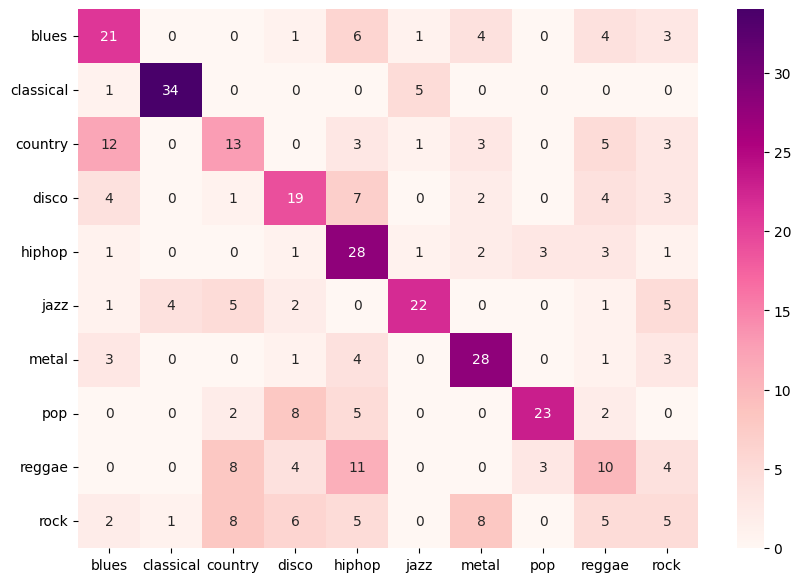

In [25]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx8.png',bbox_inches = 'tight')

## TL+LSTM2


In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(lstm_input) # 使用LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3672064   
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/500
19/19 [==============================] - 25s 1s/step - loss: 1.8299 - accuracy: 0.3417 - val_loss: 1.8058 - val_accuracy: 0.3775
Epoch 2/500
19/19 [==============================] - 20s 1s/step - loss: 1.3340 - accuracy: 0.5117 - val_loss: 1.6988 - val_accuracy: 0.3825
Epoch 3/500
19/19 [==============================] - 18s 970ms/step - loss: 1.1119 - accuracy: 0.6017 - val_loss: 1.5475 - val_accuracy: 0.3975
Epoch 4/500
19/19 [==============================] - 14s 747ms/step - loss: 0.9681 - accuracy: 0.6733 - val_loss: 1.4686 - val_accuracy: 0.4825
Epoch 5/500
19/19 [==============================] - 14s 766ms/step - loss: 0.8932 - accuracy: 0.6650 - val_loss: 1.4309 - val_accuracy: 0.4875
Epoch 6/500
19/19 [==============================] - 14s 741ms/step - loss: 0.7843 - accuracy: 0.7200 - val_loss: 1.4251 - val_accuracy: 0.5075
Epoch 7/500
19/19 [==============================] - 15s 832ms/step - loss: 0.6980 - accuracy: 0.7583 - val_loss: 1.4064 - val_accuracy: 0.505

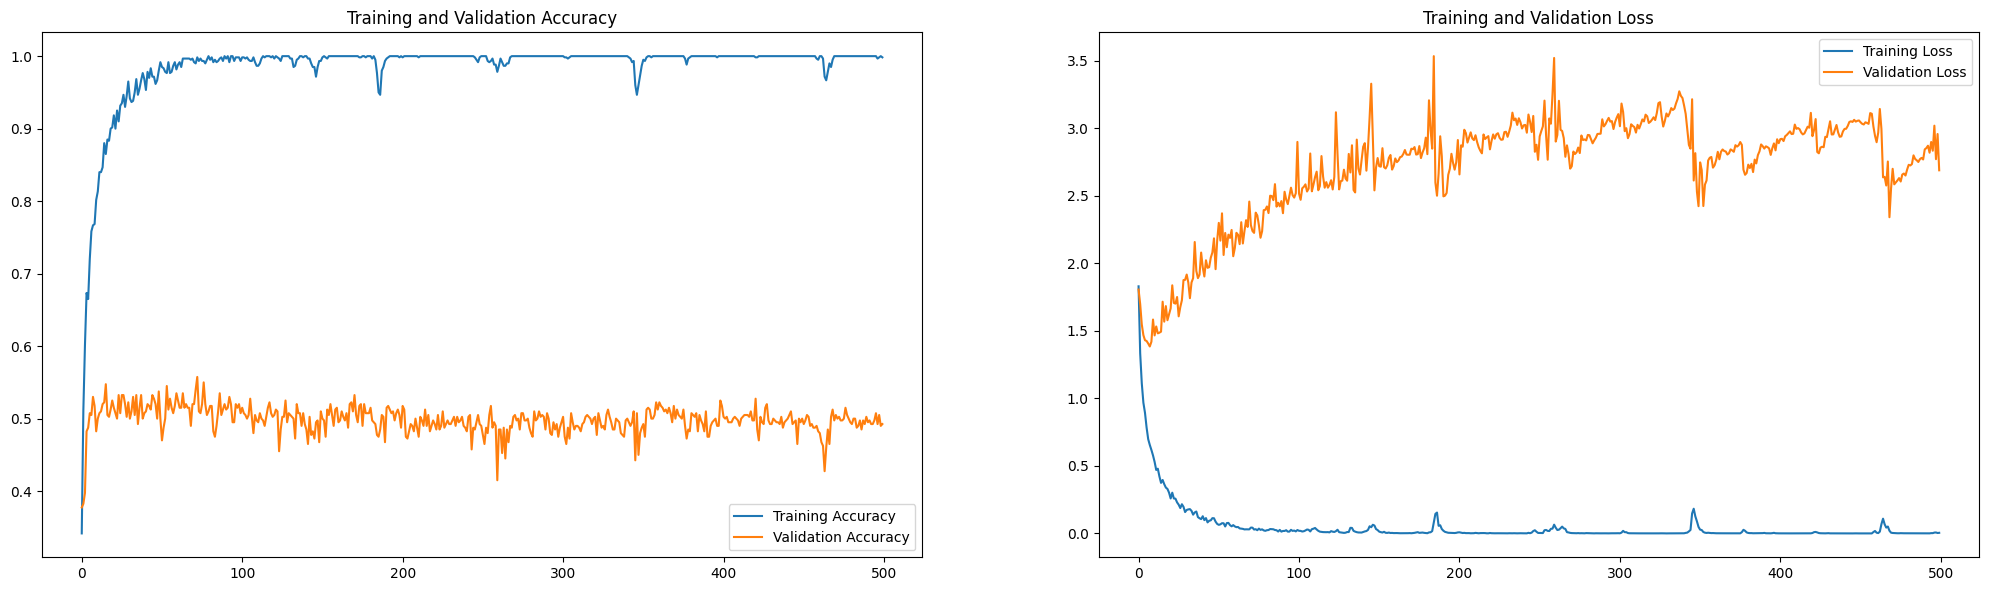

13/13 [==============================] - 6s 379ms/step
              precision    recall  f1-score   support

       blues       0.41      0.50      0.45        40
   classical       0.82      0.82      0.82        40
     country       0.37      0.35      0.36        40
       disco       0.39      0.47      0.43        40
      hiphop       0.39      0.57      0.46        40
        jazz       0.74      0.65      0.69        40
       metal       0.63      0.55      0.59        40
         pop       0.70      0.57      0.63        40
      reggae       0.36      0.20      0.26        40
        rock       0.23      0.23      0.23        40

    accuracy                           0.49       400
   macro avg       0.50      0.49      0.49       400
weighted avg       0.50      0.49      0.49       400



<Figure size 1500x600 with 0 Axes>

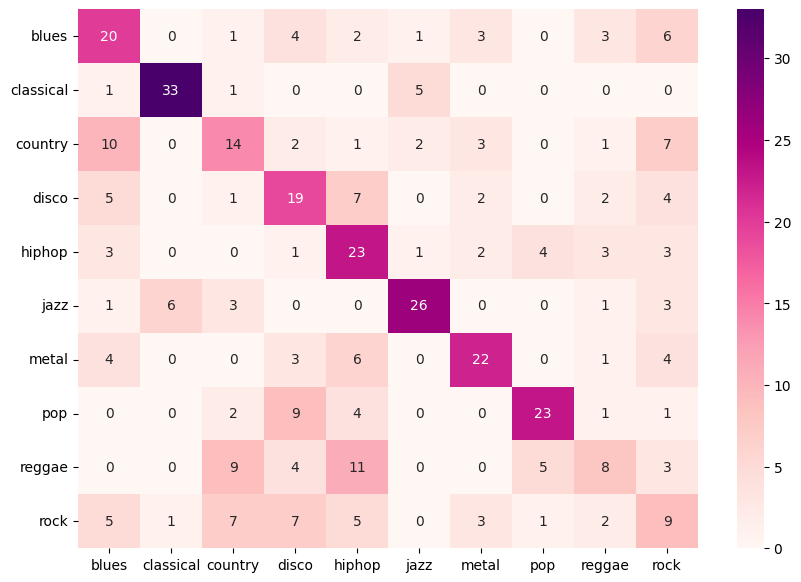

In [11]:
history8 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500)
import pickle
model.save_weights('500_epoch_tr_LSTM2.cpkt')

pickle.dump(history8.history, open('history_500_epoch_tr_LSTM2.pkl','wb'))
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_500_epoch_tr_LSTM2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_LSTM2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx9.png',bbox_inches = 'tight')

## TL+RNN2

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
rnn_layer = keras.layers.SimpleRNN(512, return_sequences=True, dropout=0.2)(lstm_input) # 使用RNN處理特徵序列
rnn_output = Flatten()(rnn_layer)  # 將RNN輸出扁平化
output = Dense(10, activation='softmax')(rnn_output) # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 512)            918016    
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/500
19/19 [==============================] - 21s 962ms/step - loss: 1.9466 - accuracy: 0.3517 - val_loss: 1.7299 - val_accuracy: 0.3750
Epoch 2/500
19/19 [==============================] - 16s 859ms/step - loss: 1.2913 - accuracy: 0.5417 - val_loss: 1.8363 - val_accuracy: 0.3650
Epoch 3/500
19/19 [==============================] - 15s 805ms/step - loss: 1.0840 - accuracy: 0.6183 - val_loss: 1.5455 - val_accuracy: 0.4100
Epoch 4/500
19/19 [==============================] - 15s 789ms/step - loss: 0.9351 - accuracy: 0.6533 - val_loss: 1.5240 - val_accuracy: 0.4800
Epoch 5/500
19/19 [==============================] - 15s 791ms/step - loss: 0.8253 - accuracy: 0.7117 - val_loss: 1.4892 - val_accuracy: 0.4575
Epoch 6/500
19/19 [==============================] - 14s 779ms/step - loss: 0.8056 - accuracy: 0.7050 - val_loss: 1.5274 - val_accuracy: 0.4550
Epoch 7/500
19/19 [==============================] - 17s 928ms/step - loss: 0.7797 - accuracy: 0.7233 - val_loss: 1.5171 - val_accuracy:

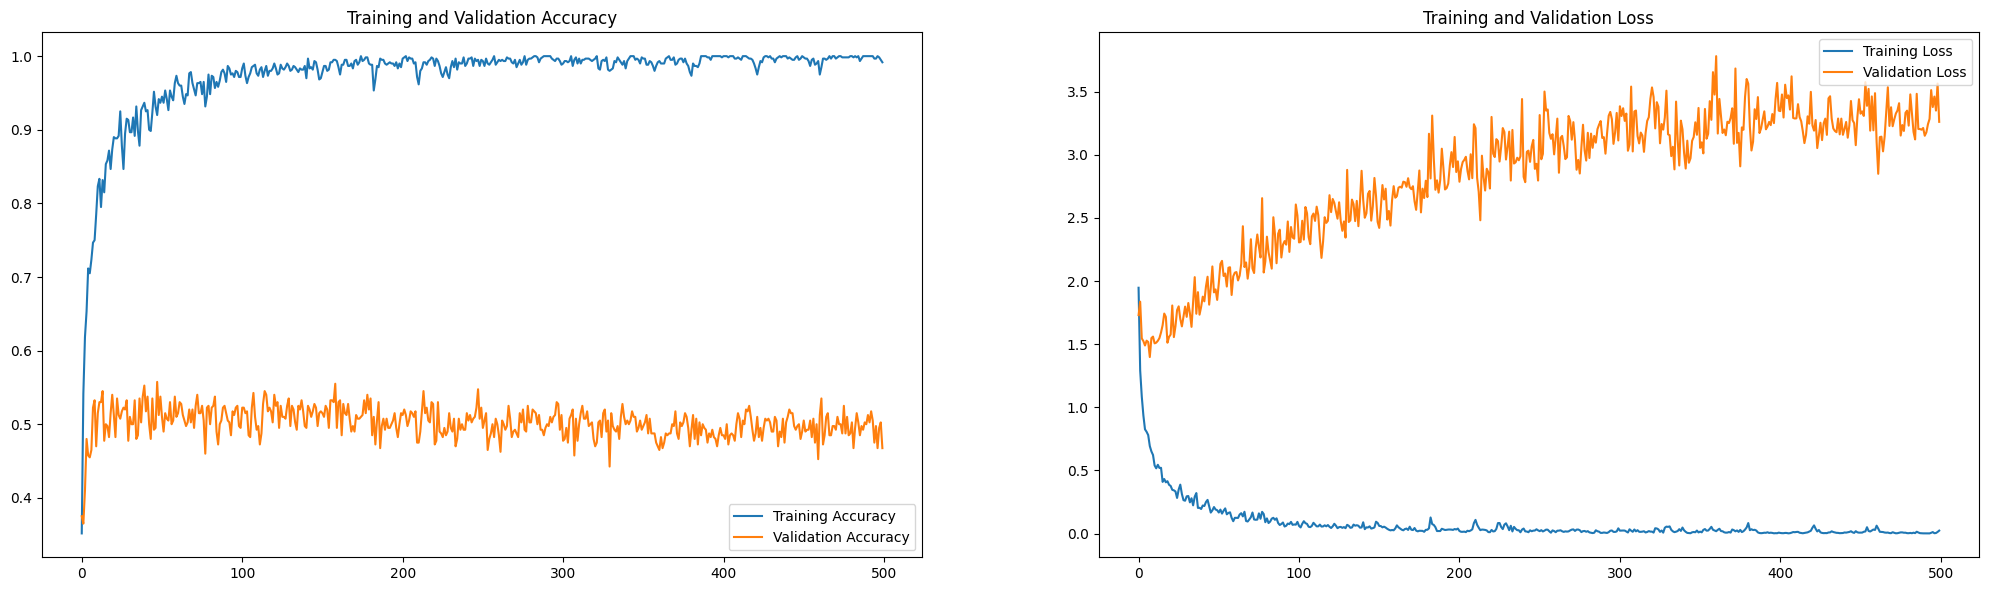

13/13 [==============================] - 7s 490ms/step
              precision    recall  f1-score   support

       blues       0.40      0.60      0.48        40
   classical       0.86      0.62      0.72        40
     country       0.27      0.33      0.29        40
       disco       0.36      0.35      0.35        40
      hiphop       0.46      0.62      0.53        40
        jazz       0.65      0.55      0.59        40
       metal       0.55      0.75      0.63        40
         pop       0.79      0.47      0.59        40
      reggae       0.33      0.17      0.23        40
        rock       0.23      0.20      0.21        40

    accuracy                           0.47       400
   macro avg       0.49      0.47      0.46       400
weighted avg       0.49      0.47      0.46       400



<Figure size 1500x600 with 0 Axes>

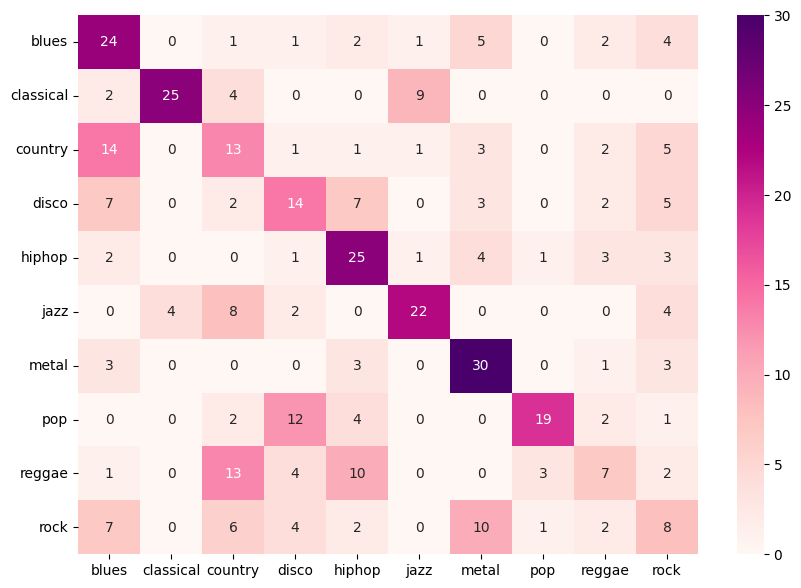

In [11]:
history9 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500)
import pickle
model.save_weights('500_epoch_tr_RNN2.cpkt')

pickle.dump(history9.history, open('history_500_epoch_tr_RNN2.pkl','wb'))
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_500_epoch_tr_RNN2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_RNN2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx10.png',bbox_inches = 'tight')

## TL+GRU2

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])


model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

Epoch 1/500
19/19 [==============================] - 29s 1s/step - loss: 1.9019 - accuracy: 0.3250 - val_loss: 1.8521 - val_accuracy: 0.3125
Epoch 2/500
19/19 [==============================] - 19s 1s/step - loss: 1.3493 - accuracy: 0.5233 - val_loss: 1.5824 - val_accuracy: 0.3825
Epoch 3/500
19/19 [==============================] - 18s 992ms/step - loss: 1.0757 - accuracy: 0.6117 - val_loss: 1.8117 - val_accuracy: 0.3400
Epoch 4/500
19/19 [==============================] - 19s 995ms/step - loss: 1.0201 - accuracy: 0.6467 - val_loss: 1.5773 - val_accuracy: 0.4600
Epoch 5/500
19/19 [==============================] - 19s 1s/step - loss: 0.8842 - accuracy: 0.6667 - val_loss: 1.6317 - val_accuracy: 0.4725
Epoch 6/500
19/19 [==============================] - 18s 989ms/step - loss: 0.7634 - accuracy: 0.7133 - val_loss: 1.4264 - val_accuracy: 0.5050
Epoch 7/500
19/19 [==============================] - 18s 985ms/step - loss: 0.6601 - accuracy: 0.7700 - val_loss: 1.4077 - val_accuracy: 0.4925
E

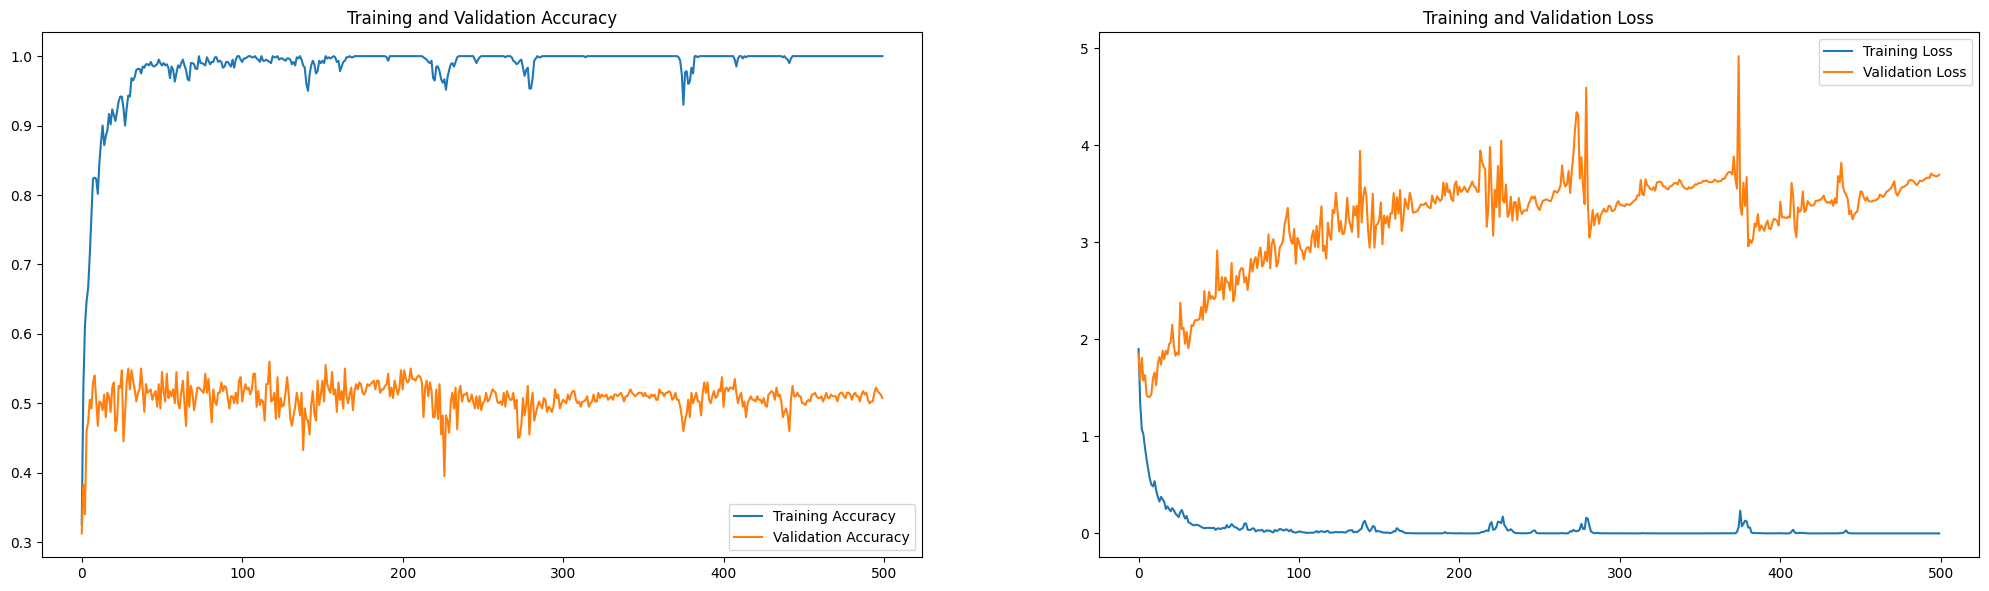

13/13 [==============================] - 7s 416ms/step
              precision    recall  f1-score   support

       blues       0.43      0.47      0.45        40
   classical       0.81      0.88      0.84        40
     country       0.42      0.42      0.42        40
       disco       0.41      0.50      0.45        40
      hiphop       0.43      0.68      0.52        40
        jazz       0.72      0.53      0.61        40
       metal       0.67      0.60      0.63        40
         pop       0.76      0.65      0.70        40
      reggae       0.24      0.23      0.23        40
        rock       0.20      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400



<Figure size 1500x600 with 0 Axes>

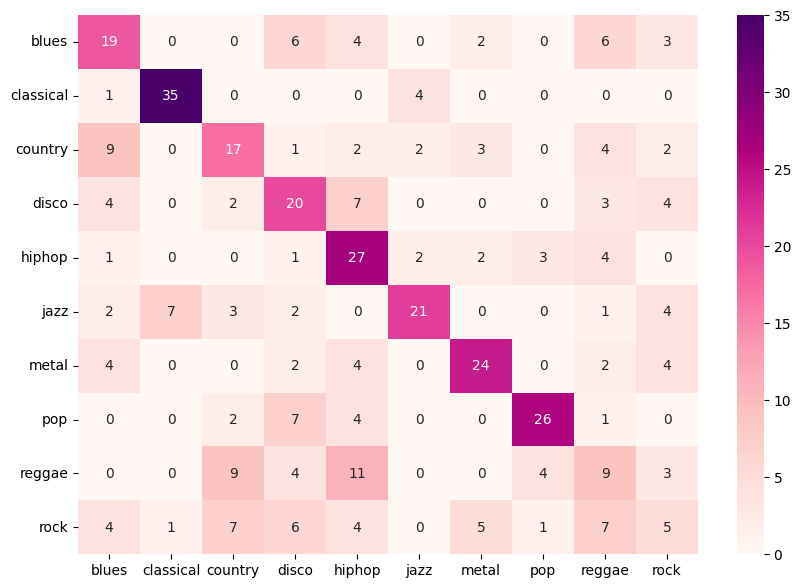

In [11]:

history9 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500)
import pickle
model.save_weights('500_epoch_tr_GRU2.cpkt')

pickle.dump(history9.history, open('history_500_epoch_tr_GRU2.pkl','wb'))
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_500_epoch_tr_GRU2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_GRU2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx11.png',bbox_inches = 'tight')

## TL+ GRU(改model.compile)

In [28]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#             metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
# 打印模型摘要
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 reshape_7 (Reshape)         (None, 1, 1280)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 1024)          5511168   
 nal)                                                            
                                                           

Epoch 1/100
19/19 [==============================] - 26s 1s/step - loss: 1.8742 - accuracy: 0.3433 - val_loss: 1.8267 - val_accuracy: 0.3325
Epoch 2/100
19/19 [==============================] - 20s 1s/step - loss: 1.2849 - accuracy: 0.5333 - val_loss: 1.6404 - val_accuracy: 0.4300
Epoch 3/100
19/19 [==============================] - 19s 1s/step - loss: 1.0907 - accuracy: 0.6167 - val_loss: 1.6890 - val_accuracy: 0.4150
Epoch 4/100
19/19 [==============================] - 19s 1s/step - loss: 1.0092 - accuracy: 0.6317 - val_loss: 1.4926 - val_accuracy: 0.4450
Epoch 5/100
19/19 [==============================] - 19s 1s/step - loss: 0.8477 - accuracy: 0.6867 - val_loss: 1.5301 - val_accuracy: 0.4725
Epoch 6/100
19/19 [==============================] - 19s 1s/step - loss: 0.7505 - accuracy: 0.7417 - val_loss: 1.3872 - val_accuracy: 0.5150
Epoch 7/100
19/19 [==============================] - 19s 1s/step - loss: 0.6451 - accuracy: 0.7583 - val_loss: 1.6614 - val_accuracy: 0.4525
Epoch 8/100
1

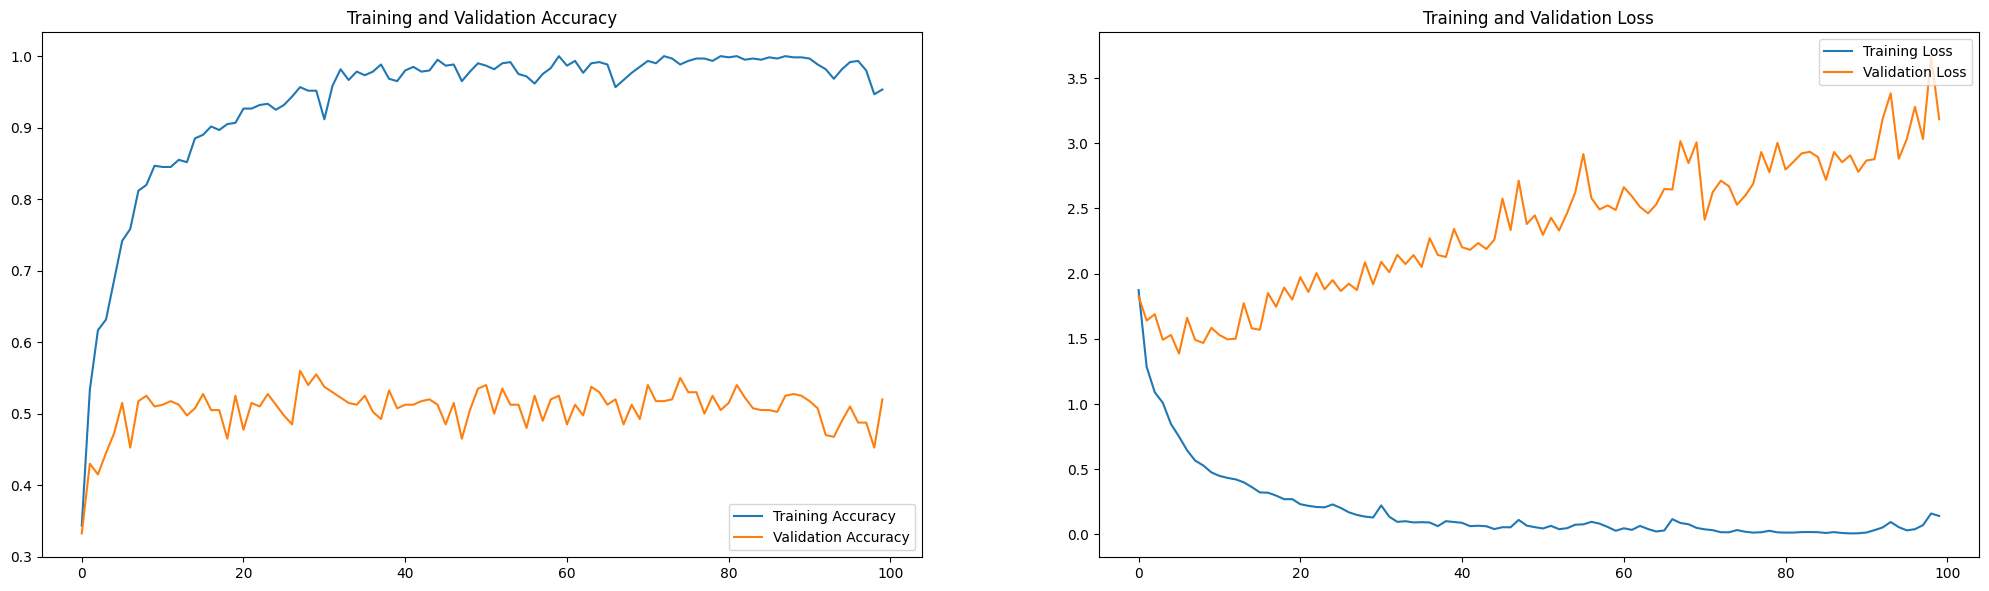

13/13 [==============================] - 8s 555ms/step
              precision    recall  f1-score   support

       blues       0.51      0.55      0.53        40
   classical       0.80      0.97      0.88        40
     country       0.30      0.65      0.41        40
       disco       0.38      0.57      0.46        40
      hiphop       0.51      0.70      0.59        40
        jazz       0.74      0.35      0.47        40
       metal       0.77      0.57      0.66        40
         pop       0.70      0.70      0.70        40
      reggae       0.44      0.10      0.16        40
        rock       0.12      0.03      0.04        40

    accuracy                           0.52       400
   macro avg       0.53      0.52      0.49       400
weighted avg       0.53      0.52      0.49       400



<Figure size 1500x600 with 0 Axes>

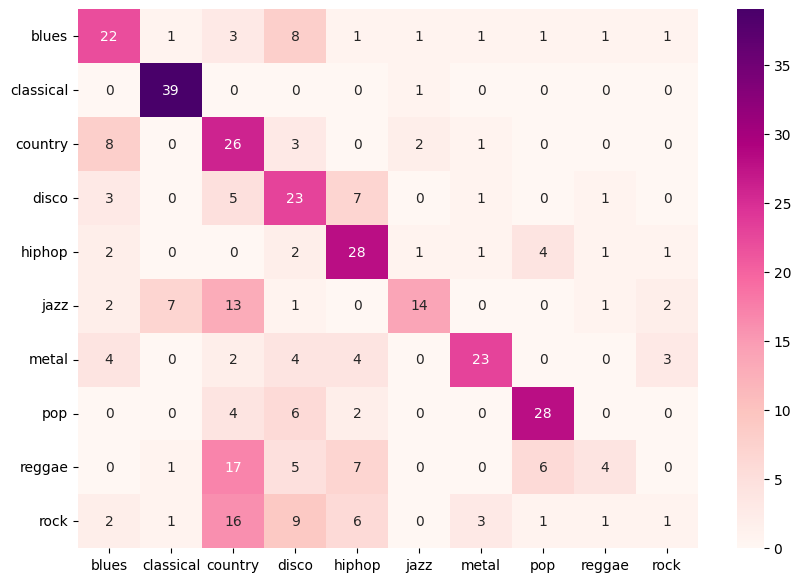

In [29]:

history12 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
import pickle
model.save_weights('100_epoch_tr_GRU.cpkt')

pickle.dump(history12.history, open('history_100_epoch_tr_GRU.pkl','wb'))
acc = history12.history['accuracy']
val_acc = history12.history['val_accuracy']
loss = history12.history['loss']
val_loss = history12.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx13.png',bbox_inches = 'tight')

## TL+100_GRU(多加batch_size=128)

### model.compile改成optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),

In [10]:
# model = tf.keras.Sequential([mobilenetv2,
#                                  tf.keras.layers.GlobalAveragePooling2D(),
#                                  tf.keras.layers.Dropout(0.2),
#                                  tf.keras.layers.Dense(10, activation="softmax")                                     
#                                 ])
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
base_learning_rate=0.0001
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    metrics=['accuracy']
)
# optimizer='adam',
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

In [11]:
history13=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100,verbose=2)

Epoch 1/100
19/19 - 27s - loss: 1.8782 - accuracy: 0.3533 - val_loss: 1.8330 - val_accuracy: 0.2925 - 27s/epoch - 1s/step
Epoch 2/100
19/19 - 19s - loss: 1.2666 - accuracy: 0.5450 - val_loss: 1.6642 - val_accuracy: 0.3850 - 19s/epoch - 1s/step
Epoch 3/100
19/19 - 20s - loss: 1.0344 - accuracy: 0.6233 - val_loss: 1.6366 - val_accuracy: 0.3875 - 20s/epoch - 1s/step
Epoch 4/100
19/19 - 20s - loss: 0.8785 - accuracy: 0.6950 - val_loss: 1.5630 - val_accuracy: 0.4625 - 20s/epoch - 1s/step
Epoch 5/100
19/19 - 22s - loss: 0.8015 - accuracy: 0.7150 - val_loss: 1.5415 - val_accuracy: 0.4750 - 22s/epoch - 1s/step
Epoch 6/100
19/19 - 20s - loss: 0.7197 - accuracy: 0.7567 - val_loss: 1.5429 - val_accuracy: 0.4825 - 20s/epoch - 1s/step
Epoch 7/100
19/19 - 21s - loss: 0.6260 - accuracy: 0.7917 - val_loss: 1.4159 - val_accuracy: 0.5225 - 21s/epoch - 1s/step
Epoch 8/100
19/19 - 21s - loss: 0.6107 - accuracy: 0.7700 - val_loss: 1.6302 - val_accuracy: 0.5050 - 21s/epoch - 1s/step
Epoch 9/100
19/19 - 20s 

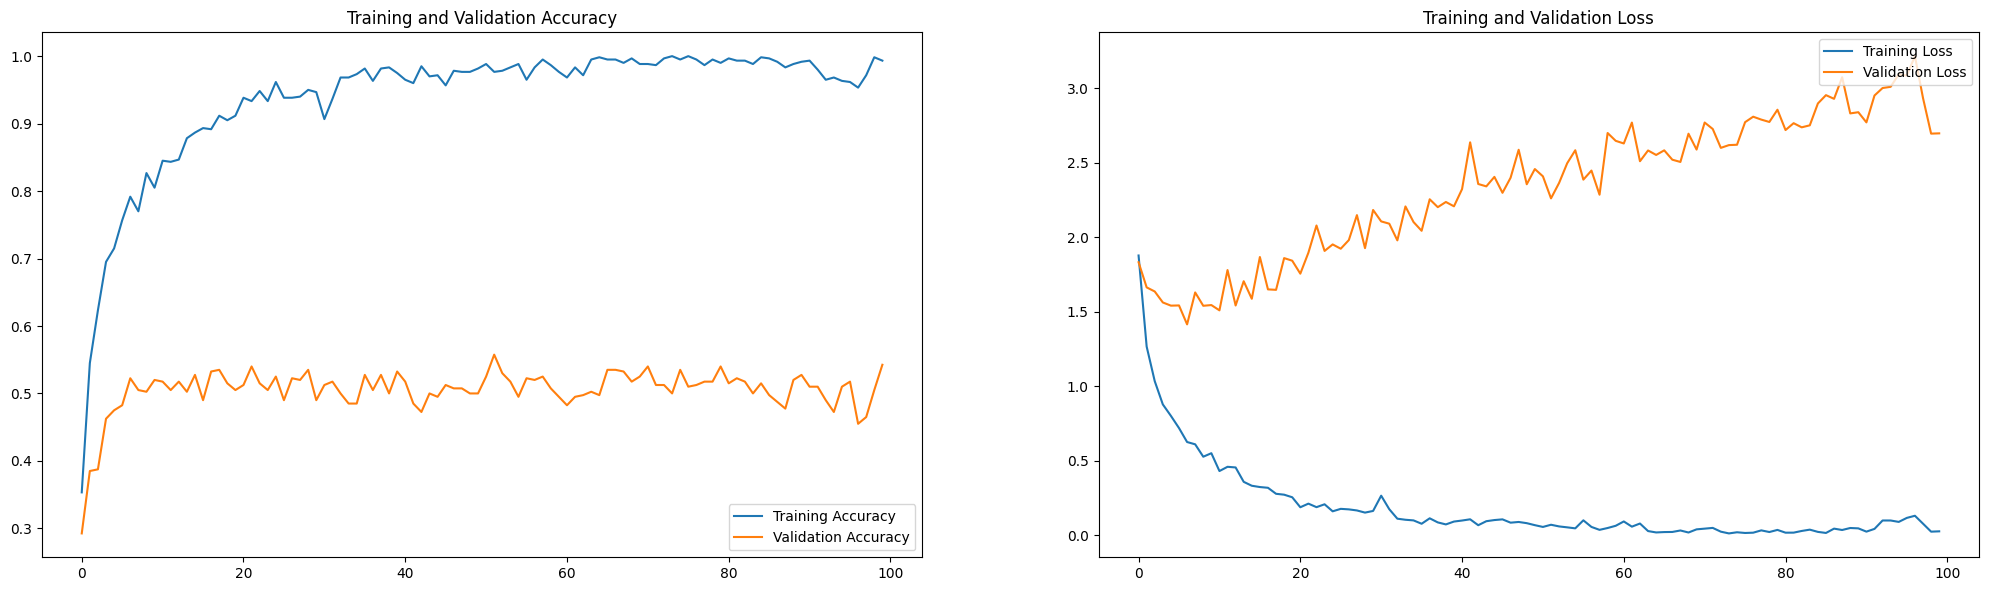

13/13 [==============================] - 8s 580ms/step
              precision    recall  f1-score   support

       blues       0.51      0.47      0.49        40
   classical       0.83      0.88      0.85        40
     country       0.46      0.40      0.43        40
       disco       0.45      0.55      0.49        40
      hiphop       0.47      0.65      0.55        40
        jazz       0.69      0.62      0.66        40
       metal       0.58      0.75      0.65        40
         pop       0.75      0.68      0.71        40
      reggae       0.28      0.30      0.29        40
        rock       0.33      0.12      0.18        40

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.53       400
weighted avg       0.54      0.54      0.53       400



<Figure size 1500x600 with 0 Axes>

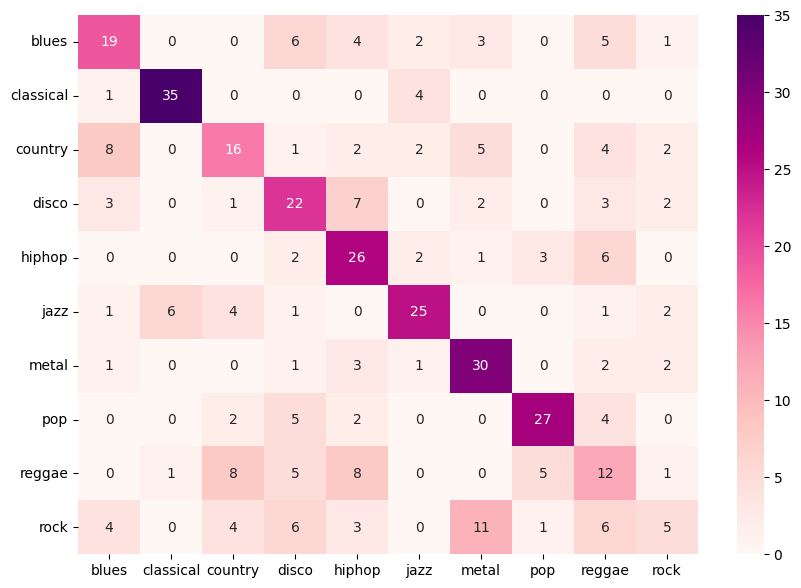

In [13]:
import pickle
model.save_weights('100_epoch_tr_GRU4.cpkt')

pickle.dump(history13.history, open('history_100_epoch_tr_GRU4.pkl','wb'))
acc = history13.history['accuracy']
val_acc = history13.history['val_accuracy']
loss = history13.history['loss']
val_loss = history13.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU4.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU4_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx24.png',bbox_inches = 'tight')

### 原版

Epoch 1/100
5/5 - 19s - loss: 2.3591 - accuracy: 0.1900 - val_loss: 2.3159 - val_accuracy: 0.2275 - 19s/epoch - 4s/step
Epoch 2/100
5/5 - 13s - loss: 1.8197 - accuracy: 0.3600 - val_loss: 1.8275 - val_accuracy: 0.3175 - 13s/epoch - 3s/step
Epoch 3/100
5/5 - 13s - loss: 1.3859 - accuracy: 0.4950 - val_loss: 1.8025 - val_accuracy: 0.3550 - 13s/epoch - 3s/step
Epoch 4/100
5/5 - 13s - loss: 1.2904 - accuracy: 0.5167 - val_loss: 1.7477 - val_accuracy: 0.3600 - 13s/epoch - 3s/step
Epoch 5/100
5/5 - 13s - loss: 1.1440 - accuracy: 0.5933 - val_loss: 1.7164 - val_accuracy: 0.3625 - 13s/epoch - 3s/step
Epoch 6/100
5/5 - 13s - loss: 1.0816 - accuracy: 0.6100 - val_loss: 1.5760 - val_accuracy: 0.4075 - 13s/epoch - 3s/step
Epoch 7/100
5/5 - 13s - loss: 0.9658 - accuracy: 0.6367 - val_loss: 1.4871 - val_accuracy: 0.4550 - 13s/epoch - 3s/step
Epoch 8/100
5/5 - 13s - loss: 0.8939 - accuracy: 0.6850 - val_loss: 1.4793 - val_accuracy: 0.4500 - 13s/epoch - 3s/step
Epoch 9/100
5/5 - 13s - loss: 0.8272 - a

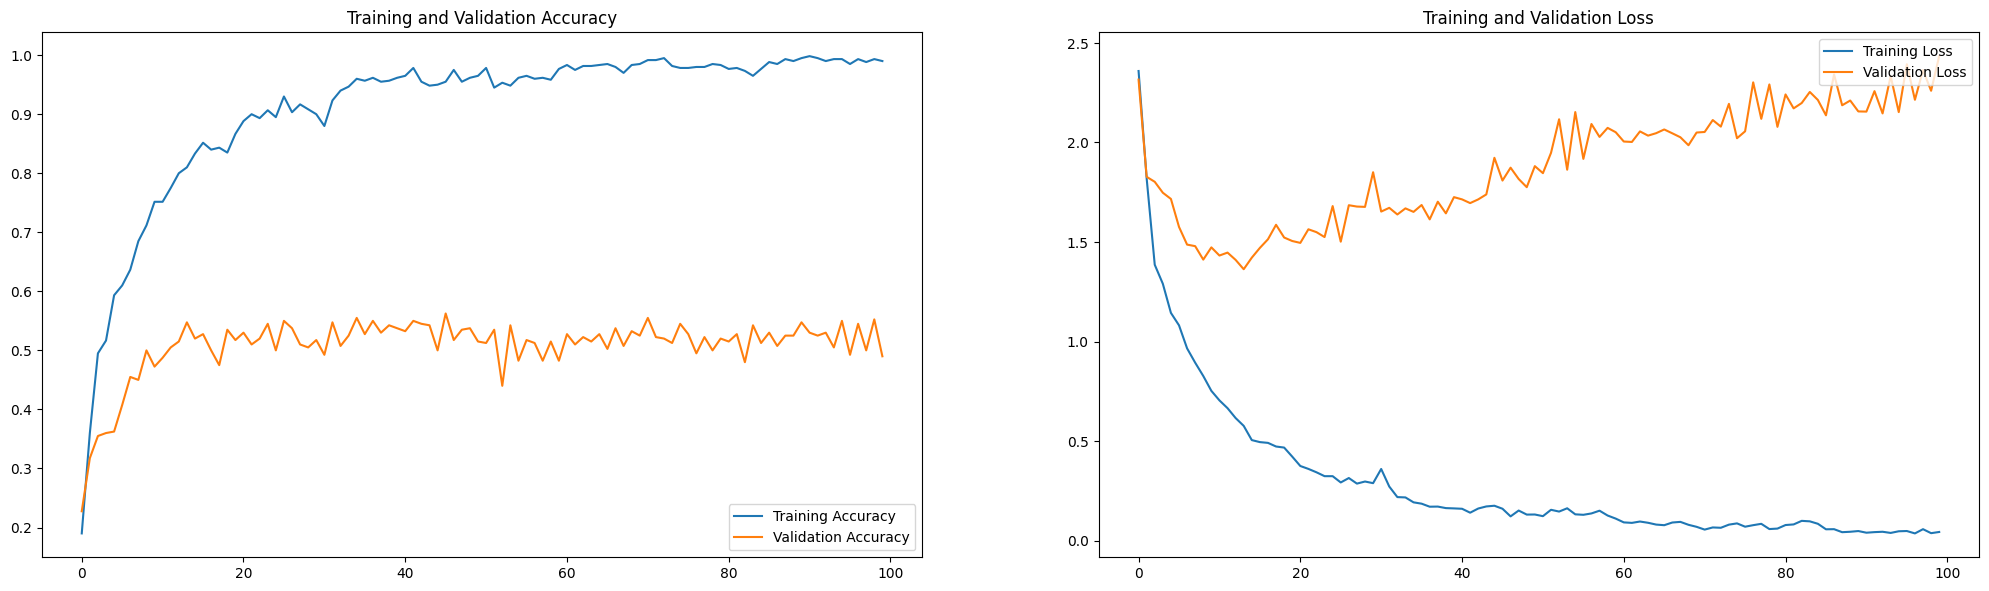

13/13 [==============================] - 7s 428ms/step
              precision    recall  f1-score   support

       blues       0.41      0.53      0.46        40
   classical       0.84      0.80      0.82        40
     country       0.42      0.42      0.42        40
       disco       0.30      0.53      0.38        40
      hiphop       0.43      0.75      0.55        40
        jazz       0.81      0.55      0.66        40
       metal       0.67      0.45      0.54        40
         pop       0.81      0.42      0.56        40
      reggae       0.36      0.23      0.28        40
        rock       0.29      0.23      0.25        40

    accuracy                           0.49       400
   macro avg       0.54      0.49      0.49       400
weighted avg       0.54      0.49      0.49       400



<Figure size 1500x600 with 0 Axes>

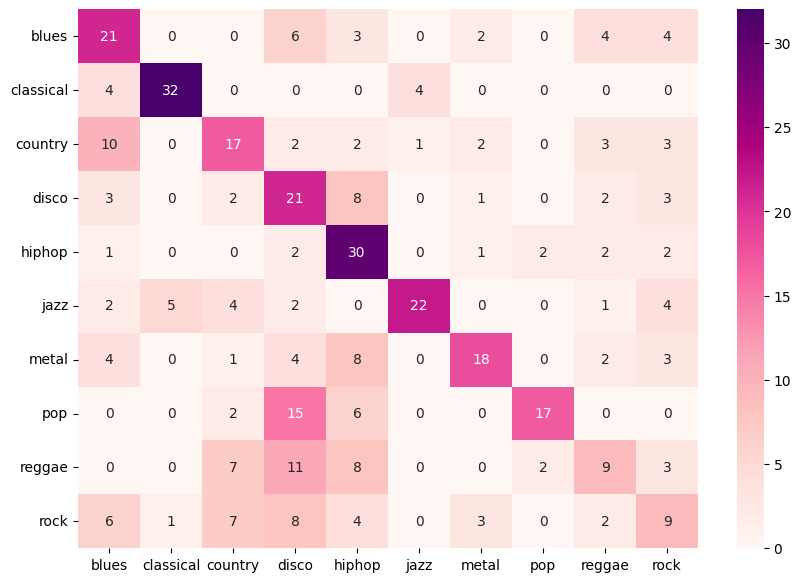

In [11]:
history13=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100, batch_size=128,verbose=2)
import pickle
model.save_weights('100_epoch_tr_GRU2.cpkt')

pickle.dump(history13.history, open('history_100_epoch_tr_GRU2.pkl','wb'))
acc = history13.history['accuracy']
val_acc = history13.history['val_accuracy']
loss = history13.history['loss']
val_loss = history13.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx14.png',bbox_inches = 'tight')

## TL+100_BiLSTM

In [14]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(lstm_input)  # 使用Bidirectional LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          7344128   
 l)                                                              
                                                             

Epoch 1/100
19/19 [==============================] - 25s 1s/step - loss: 1.7813 - accuracy: 0.3700 - val_loss: 1.8382 - val_accuracy: 0.2900
Epoch 2/100
19/19 [==============================] - 19s 1s/step - loss: 1.2764 - accuracy: 0.5400 - val_loss: 1.7586 - val_accuracy: 0.3625
Epoch 3/100
19/19 [==============================] - 18s 966ms/step - loss: 1.0590 - accuracy: 0.5933 - val_loss: 1.5365 - val_accuracy: 0.4375
Epoch 4/100
19/19 [==============================] - 21s 1s/step - loss: 0.9172 - accuracy: 0.6600 - val_loss: 1.5518 - val_accuracy: 0.4575
Epoch 5/100
19/19 [==============================] - 21s 1s/step - loss: 0.7717 - accuracy: 0.7383 - val_loss: 1.5541 - val_accuracy: 0.4625
Epoch 6/100
19/19 [==============================] - 21s 1s/step - loss: 0.6930 - accuracy: 0.7583 - val_loss: 1.3997 - val_accuracy: 0.5150
Epoch 7/100
19/19 [==============================] - 21s 1s/step - loss: 0.6249 - accuracy: 0.7617 - val_loss: 1.5825 - val_accuracy: 0.4975
Epoch 8/10

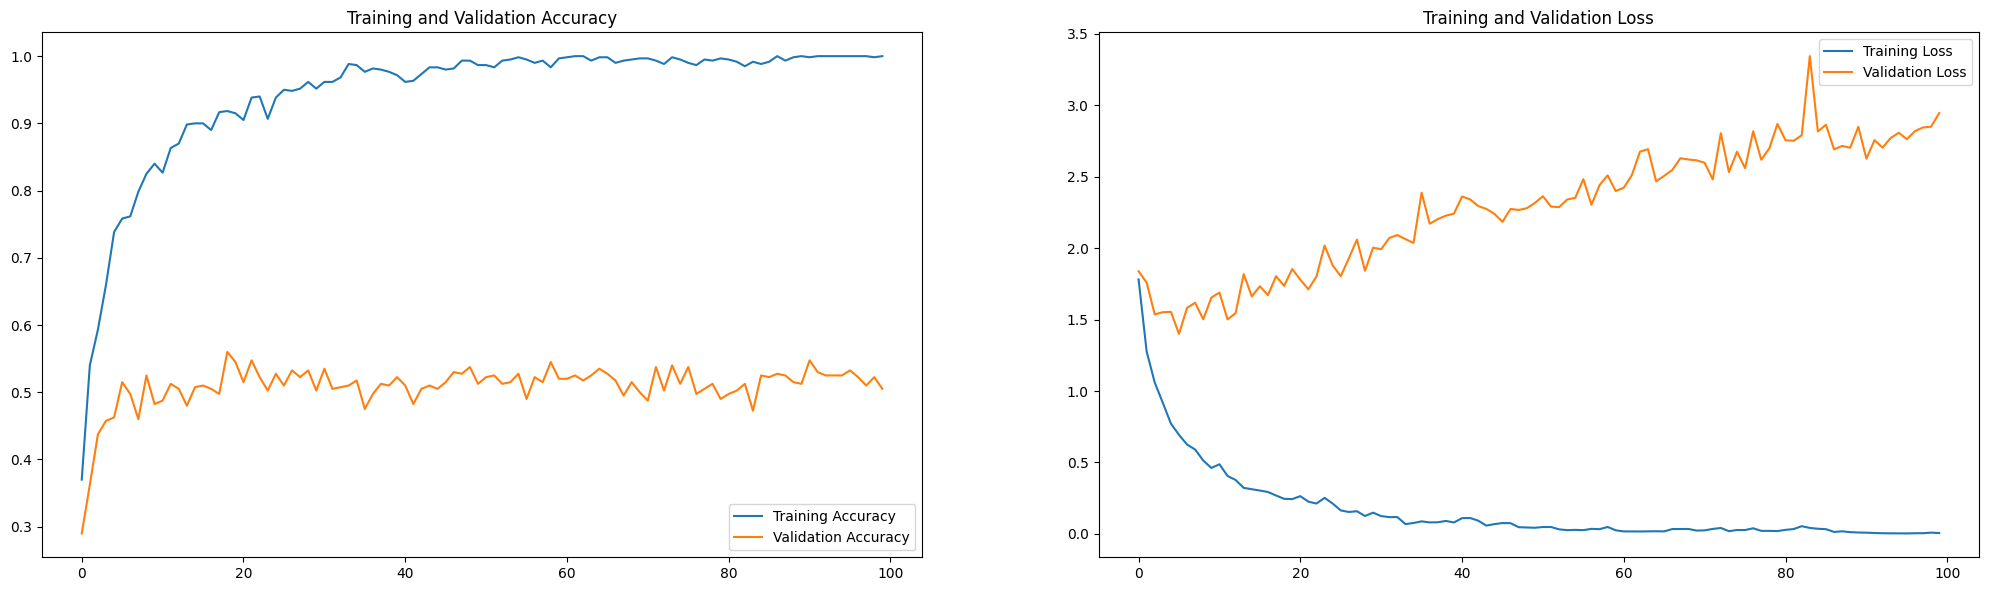

13/13 [==============================] - 6s 387ms/step
              precision    recall  f1-score   support

       blues       0.53      0.45      0.49        40
   classical       0.87      0.85      0.86        40
     country       0.41      0.38      0.39        40
       disco       0.42      0.47      0.45        40
      hiphop       0.42      0.60      0.49        40
        jazz       0.75      0.60      0.67        40
       metal       0.61      0.55      0.58        40
         pop       0.76      0.65      0.70        40
      reggae       0.23      0.38      0.28        40
        rock       0.25      0.12      0.17        40

    accuracy                           0.51       400
   macro avg       0.53      0.51      0.51       400
weighted avg       0.53      0.51      0.51       400



<Figure size 1500x600 with 0 Axes>

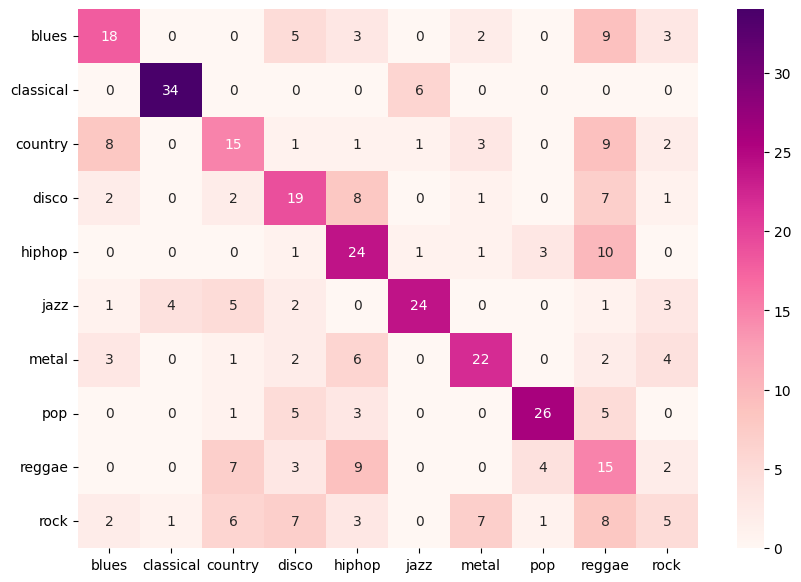

In [15]:
history14 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
import pickle
model.save_weights('100_epoch_tr_BiLSTM.cpkt')

pickle.dump(history14.history, open('history_100_epoch_tr_BiLSTM.pkl','wb'))
acc = history14.history['accuracy']
val_acc = history14.history['val_accuracy']
loss = history14.history['loss']
val_loss = history14.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_BiLSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_BiLSTM_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx15.png',bbox_inches = 'tight')

## TL+100_BiLSTM2(多加batch_size=256)

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(lstm_input)  # 使用Bidirectional LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          7344128   
 l)                                                              
                                                             

Epoch 1/100
3/3 [==============================] - 22s 6s/step - loss: 2.1739 - accuracy: 0.1733 - val_loss: 1.8779 - val_accuracy: 0.3050
Epoch 2/100
3/3 [==============================] - 14s 5s/step - loss: 1.6278 - accuracy: 0.4533 - val_loss: 1.7202 - val_accuracy: 0.3850
Epoch 3/100
3/3 [==============================] - 13s 5s/step - loss: 1.3584 - accuracy: 0.5317 - val_loss: 1.7412 - val_accuracy: 0.3300
Epoch 4/100
3/3 [==============================] - 13s 5s/step - loss: 1.2364 - accuracy: 0.5467 - val_loss: 1.7401 - val_accuracy: 0.3375
Epoch 5/100
3/3 [==============================] - 13s 5s/step - loss: 1.1240 - accuracy: 0.5900 - val_loss: 1.7515 - val_accuracy: 0.3975
Epoch 6/100
3/3 [==============================] - 13s 5s/step - loss: 1.0655 - accuracy: 0.6133 - val_loss: 1.7028 - val_accuracy: 0.3850
Epoch 7/100
3/3 [==============================] - 13s 5s/step - loss: 0.9736 - accuracy: 0.6617 - val_loss: 1.5901 - val_accuracy: 0.4300
Epoch 8/100
3/3 [==========

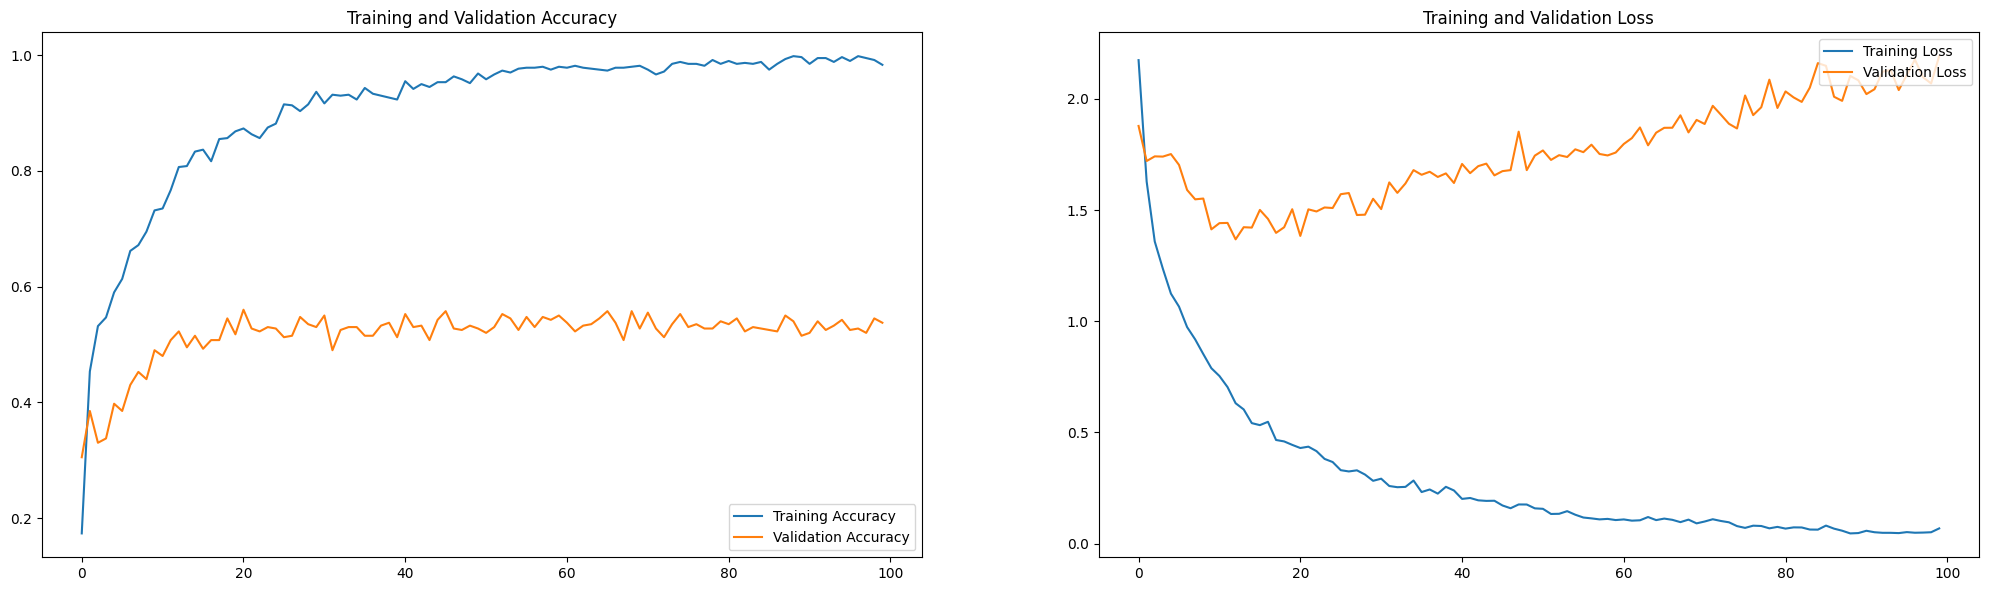

13/13 [==============================] - 6s 383ms/step
              precision    recall  f1-score   support

       blues       0.49      0.55      0.52        40
   classical       0.85      0.88      0.86        40
     country       0.38      0.45      0.41        40
       disco       0.47      0.50      0.48        40
      hiphop       0.44      0.70      0.54        40
        jazz       0.72      0.57      0.64        40
       metal       0.60      0.75      0.67        40
         pop       0.76      0.65      0.70        40
      reggae       0.30      0.20      0.24        40
        rock       0.29      0.12      0.18        40

    accuracy                           0.54       400
   macro avg       0.53      0.54      0.52       400
weighted avg       0.53      0.54      0.52       400



<Figure size 1500x600 with 0 Axes>

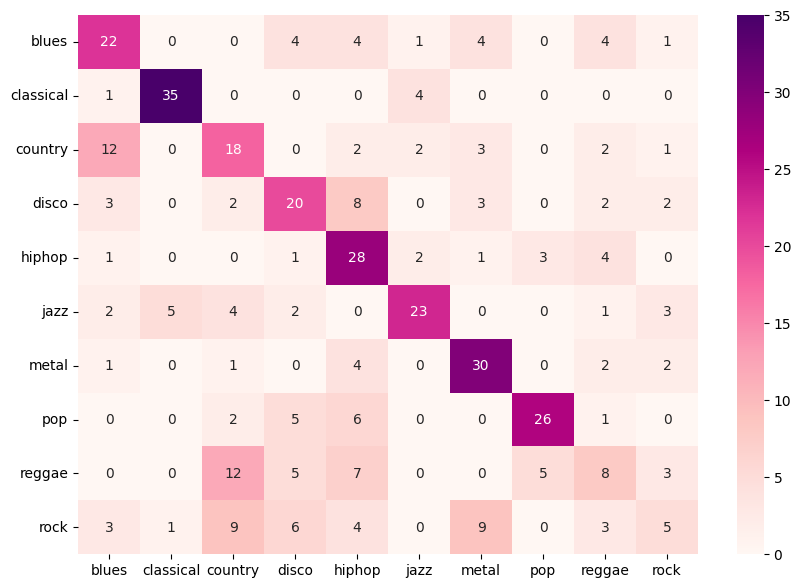

In [11]:
history18 = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=256, epochs=100)
import pickle
model.save_weights('100_epoch_tr_BiLSTM2.cpkt')

pickle.dump(history18.history, open('history_100_epoch_tr_BiLSTM2.pkl','wb'))
acc = history18.history['accuracy']
val_acc = history18.history['val_accuracy']
loss = history18.history['loss']
val_loss = history18.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_BiLSTM2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_BiLSTM2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx19.png',bbox_inches = 'tight')

## TL+100_LSTM

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(lstm_input) # 使用LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3672064   
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/100
19/19 [==============================] - 20s 881ms/step - loss: 1.8192 - accuracy: 0.3783 - val_loss: 1.8086 - val_accuracy: 0.3075
Epoch 2/100
19/19 [==============================] - 14s 766ms/step - loss: 1.3536 - accuracy: 0.4833 - val_loss: 1.6967 - val_accuracy: 0.3650
Epoch 3/100
19/19 [==============================] - 14s 739ms/step - loss: 1.2108 - accuracy: 0.5550 - val_loss: 1.6533 - val_accuracy: 0.4025
Epoch 4/100
19/19 [==============================] - 14s 777ms/step - loss: 1.0521 - accuracy: 0.6167 - val_loss: 1.5414 - val_accuracy: 0.4500
Epoch 5/100
19/19 [==============================] - 15s 789ms/step - loss: 0.9167 - accuracy: 0.6767 - val_loss: 1.5197 - val_accuracy: 0.4500
Epoch 6/100
19/19 [==============================] - 14s 737ms/step - loss: 0.8383 - accuracy: 0.7017 - val_loss: 1.5324 - val_accuracy: 0.4875
Epoch 7/100
19/19 [==============================] - 14s 739ms/step - loss: 0.7734 - accuracy: 0.7217 - val_loss: 1.5511 - val_accuracy:

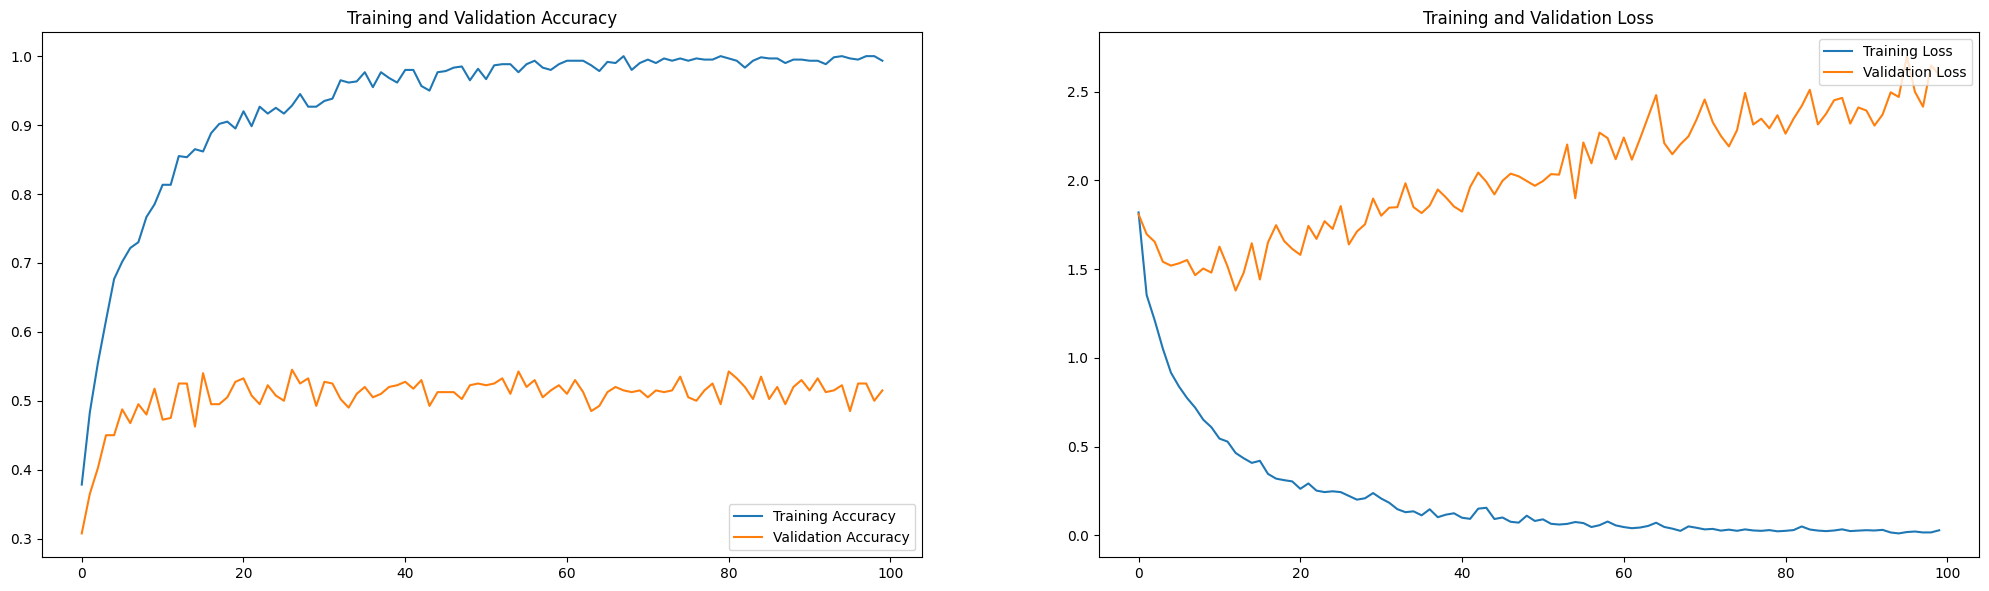

13/13 [==============================] - 6s 377ms/step
              precision    recall  f1-score   support

       blues       0.48      0.65      0.55        40
   classical       0.84      0.90      0.87        40
     country       0.34      0.38      0.36        40
       disco       0.50      0.33      0.39        40
      hiphop       0.43      0.68      0.52        40
        jazz       0.85      0.57      0.69        40
       metal       0.46      0.78      0.57        40
         pop       0.77      0.57      0.66        40
      reggae       0.34      0.25      0.29        40
        rock       0.12      0.05      0.07        40

    accuracy                           0.52       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.52      0.50       400



<Figure size 1500x600 with 0 Axes>

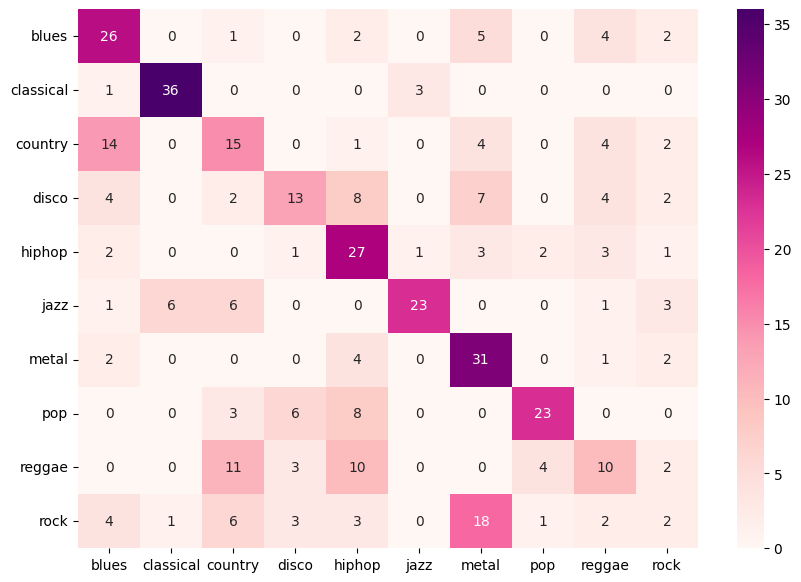

In [11]:
history15 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
import pickle
model.save_weights('100_epoch_tr_LSTM.cpkt')

pickle.dump(history15.history, open('history_100_epoch_tr_LSTM.pkl','wb'))
acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']
loss = history15.history['loss']
val_loss = history15.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_LSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_LSTM_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx16.png',bbox_inches = 'tight')

## TL+LSTM2(多加batch_size=256)

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(lstm_input) # 使用LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3672064   
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/100
3/3 [==============================] - 19s 6s/step - loss: 2.1839 - accuracy: 0.2133 - val_loss: 1.9326 - val_accuracy: 0.2975
Epoch 2/100
3/3 [==============================] - 13s 5s/step - loss: 1.7080 - accuracy: 0.4433 - val_loss: 1.7683 - val_accuracy: 0.3500
Epoch 3/100
3/3 [==============================] - 13s 5s/step - loss: 1.4291 - accuracy: 0.5133 - val_loss: 1.7161 - val_accuracy: 0.3375
Epoch 4/100
3/3 [==============================] - 13s 5s/step - loss: 1.2813 - accuracy: 0.5333 - val_loss: 1.7360 - val_accuracy: 0.3125
Epoch 5/100
3/3 [==============================] - 13s 5s/step - loss: 1.2042 - accuracy: 0.5483 - val_loss: 1.6797 - val_accuracy: 0.3875
Epoch 6/100
3/3 [==============================] - 13s 5s/step - loss: 1.1118 - accuracy: 0.5933 - val_loss: 1.6487 - val_accuracy: 0.3925
Epoch 7/100
3/3 [==============================] - 13s 5s/step - loss: 1.0436 - accuracy: 0.6100 - val_loss: 1.6415 - val_accuracy: 0.3900
Epoch 8/100
3/3 [==========

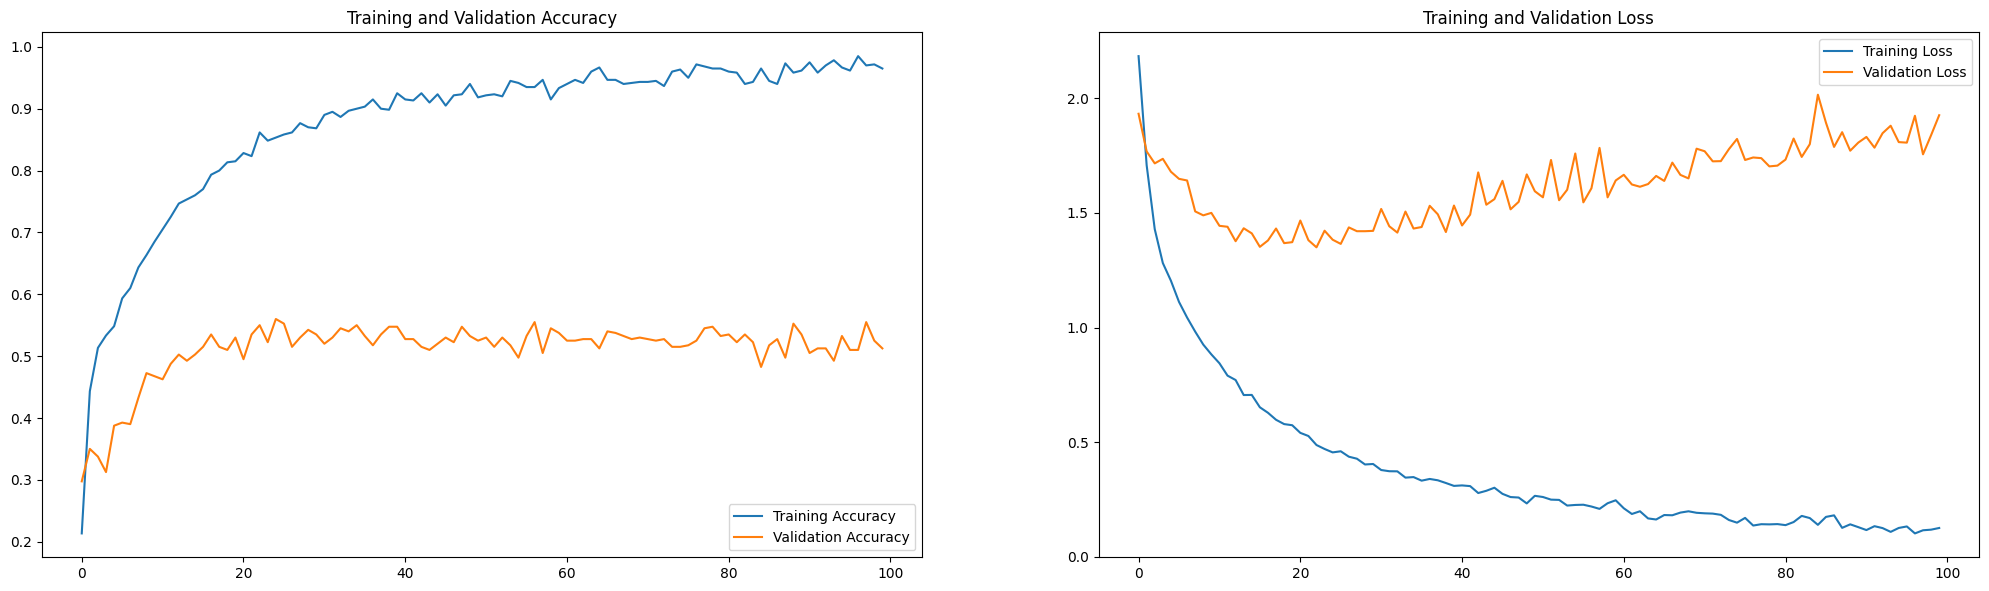

13/13 [==============================] - 6s 382ms/step
              precision    recall  f1-score   support

       blues       0.37      0.57      0.45        40
   classical       0.92      0.88      0.90        40
     country       0.44      0.35      0.39        40
       disco       0.38      0.60      0.47        40
      hiphop       0.42      0.68      0.51        40
        jazz       0.79      0.65      0.71        40
       metal       0.62      0.45      0.52        40
         pop       0.76      0.55      0.64        40
      reggae       0.40      0.20      0.27        40
        rock       0.28      0.20      0.23        40

    accuracy                           0.51       400
   macro avg       0.54      0.51      0.51       400
weighted avg       0.54      0.51      0.51       400



<Figure size 1500x600 with 0 Axes>

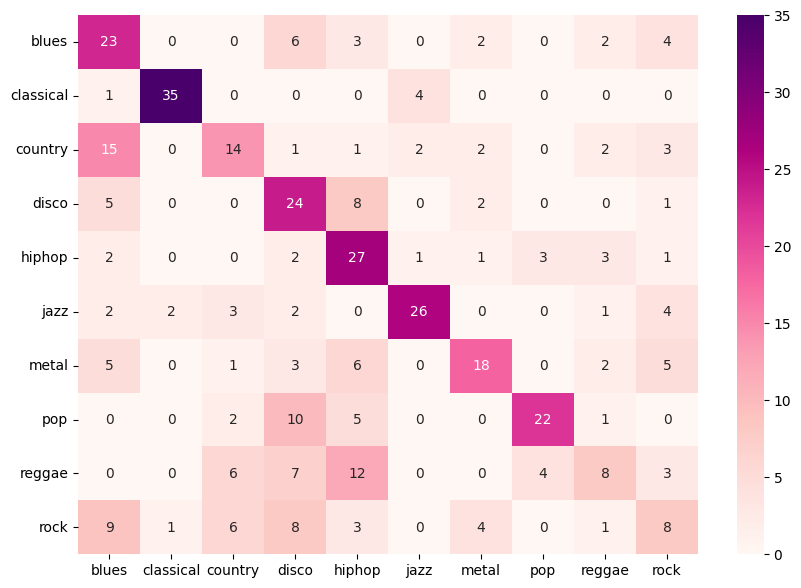

In [11]:
history19 = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=256, epochs=100)
import pickle
model.save_weights('100_epoch_tr_LSTM2.cpkt')

pickle.dump(history19.history, open('history_100_epoch_tr_LSTM2.pkl','wb'))
acc = history19.history['accuracy']
val_acc = history19.history['val_accuracy']
loss = history19.history['loss']
val_loss = history19.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_LSTM2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_LSTM2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx20.png',bbox_inches = 'tight')

## TL+100_RNN

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
rnn_layer = keras.layers.SimpleRNN(512, return_sequences=True, dropout=0.2)(lstm_input) # 使用RNN處理特徵序列
rnn_output = Flatten()(rnn_layer)  # 將RNN輸出扁平化
output = Dense(10, activation='softmax')(rnn_output) # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 512)            918016    
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/100
19/19 [==============================] - 19s 884ms/step - loss: 2.0154 - accuracy: 0.3183 - val_loss: 1.8263 - val_accuracy: 0.3600
Epoch 2/100
19/19 [==============================] - 16s 849ms/step - loss: 1.3477 - accuracy: 0.5150 - val_loss: 1.6328 - val_accuracy: 0.3875
Epoch 3/100
19/19 [==============================] - 14s 758ms/step - loss: 1.1195 - accuracy: 0.5867 - val_loss: 1.5599 - val_accuracy: 0.4725
Epoch 4/100
19/19 [==============================] - 14s 756ms/step - loss: 0.9926 - accuracy: 0.6517 - val_loss: 1.5640 - val_accuracy: 0.4375
Epoch 5/100
19/19 [==============================] - 14s 736ms/step - loss: 0.9302 - accuracy: 0.6633 - val_loss: 1.7832 - val_accuracy: 0.4050
Epoch 6/100
19/19 [==============================] - 16s 849ms/step - loss: 0.8559 - accuracy: 0.6783 - val_loss: 1.4610 - val_accuracy: 0.4875
Epoch 7/100
19/19 [==============================] - 15s 816ms/step - loss: 0.7094 - accuracy: 0.7667 - val_loss: 1.4734 - val_accuracy:

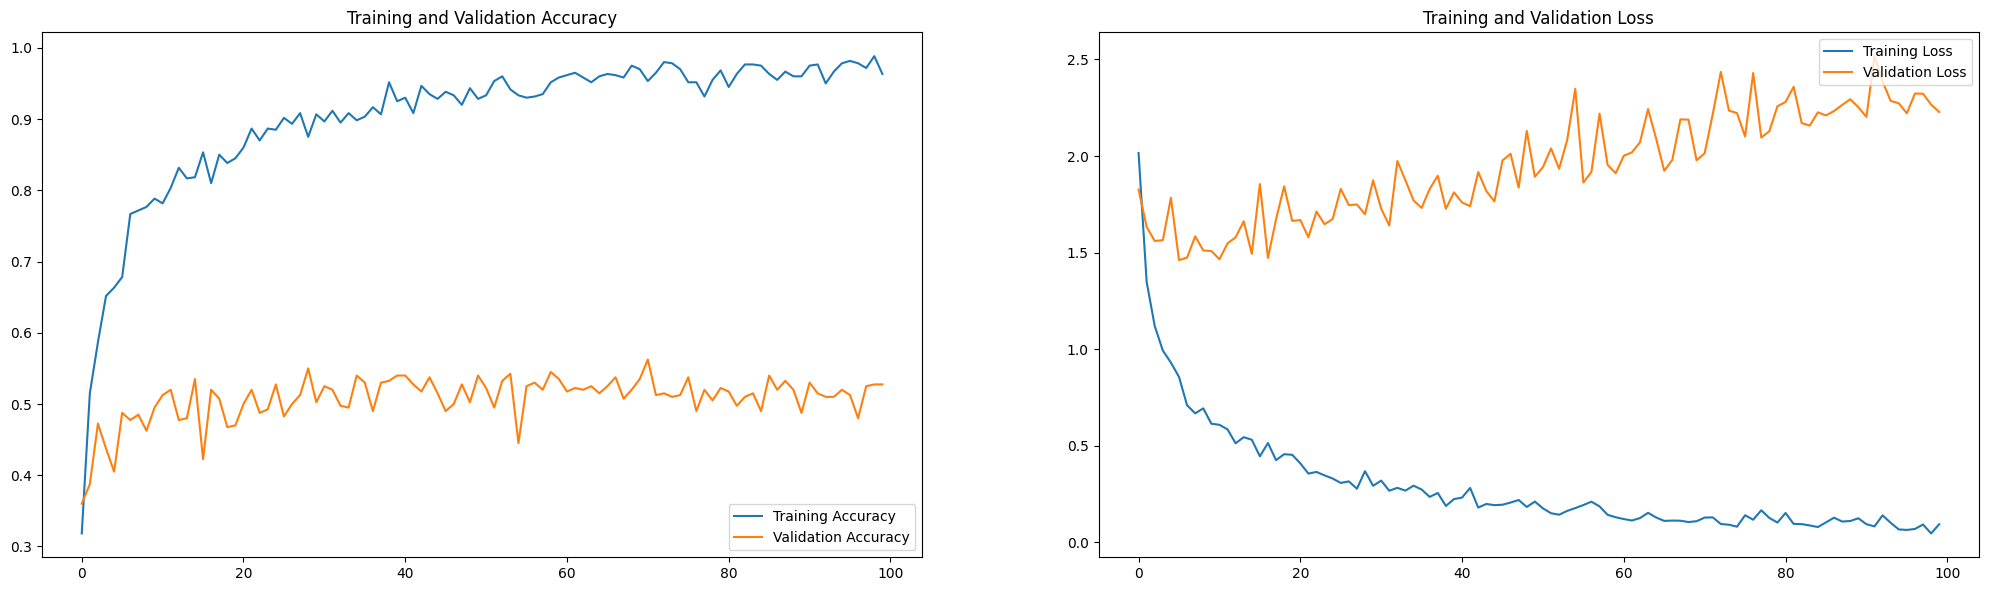

13/13 [==============================] - 8s 544ms/step
              precision    recall  f1-score   support

       blues       0.45      0.57      0.51        40
   classical       0.91      0.75      0.82        40
     country       0.40      0.35      0.37        40
       disco       0.41      0.38      0.39        40
      hiphop       0.49      0.60      0.54        40
        jazz       0.67      0.78      0.72        40
       metal       0.68      0.62      0.65        40
         pop       0.81      0.65      0.72        40
      reggae       0.35      0.28      0.31        40
        rock       0.24      0.30      0.27        40

    accuracy                           0.53       400
   macro avg       0.54      0.53      0.53       400
weighted avg       0.54      0.53      0.53       400



<Figure size 1500x600 with 0 Axes>

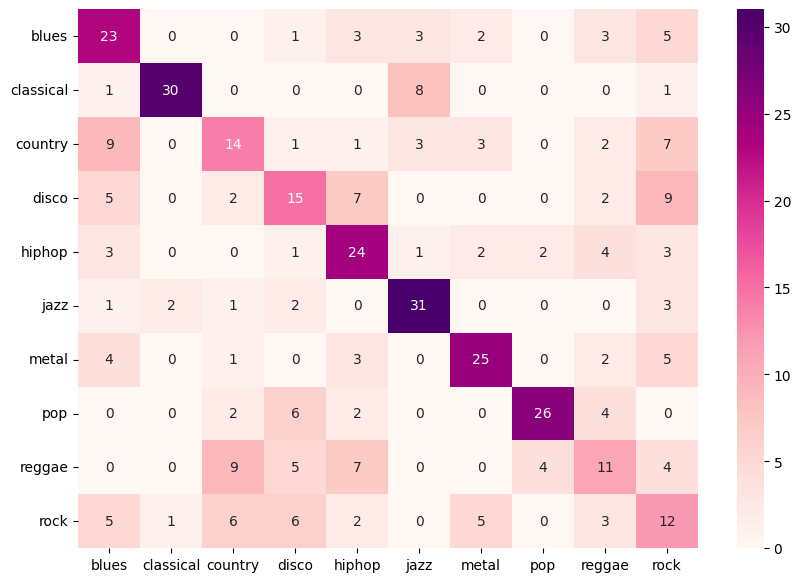

In [11]:
history16 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)
import pickle
model.save_weights('100_epoch_tr_RNN.cpkt')

pickle.dump(history16.history, open('history_100_epoch_tr_RNN.pkl','wb'))
acc = history16.history['accuracy']
val_acc = history16.history['val_accuracy']
loss = history16.history['loss']
val_loss = history16.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_RNN.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_RNN_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx17.png',bbox_inches = 'tight')

## TL+RNN2(多加batch_size=256)

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
rnn_layer = keras.layers.SimpleRNN(512, return_sequences=True, dropout=0.2)(lstm_input) # 使用RNN處理特徵序列
rnn_output = Flatten()(rnn_layer)  # 將RNN輸出扁平化
output = Dense(10, activation='softmax')(rnn_output) # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 512)            918016    
                                                                 
 flatten (Flatten)           (None, 512)               0     

Epoch 1/100
3/3 [==============================] - 20s 6s/step - loss: 2.2622 - accuracy: 0.1867 - val_loss: 1.9919 - val_accuracy: 0.3525
Epoch 2/100
3/3 [==============================] - 18s 7s/step - loss: 1.6957 - accuracy: 0.4133 - val_loss: 1.8184 - val_accuracy: 0.3125
Epoch 3/100
3/3 [==============================] - 17s 6s/step - loss: 1.4152 - accuracy: 0.4717 - val_loss: 1.7625 - val_accuracy: 0.3125
Epoch 4/100
3/3 [==============================] - 17s 6s/step - loss: 1.2867 - accuracy: 0.5317 - val_loss: 1.7542 - val_accuracy: 0.3875
Epoch 5/100
3/3 [==============================] - 18s 7s/step - loss: 1.1998 - accuracy: 0.5383 - val_loss: 1.6690 - val_accuracy: 0.3875
Epoch 6/100
3/3 [==============================] - 19s 7s/step - loss: 1.1171 - accuracy: 0.6000 - val_loss: 1.6206 - val_accuracy: 0.4100
Epoch 7/100
3/3 [==============================] - 17s 6s/step - loss: 1.0852 - accuracy: 0.6100 - val_loss: 1.5811 - val_accuracy: 0.3850
Epoch 8/100
3/3 [==========

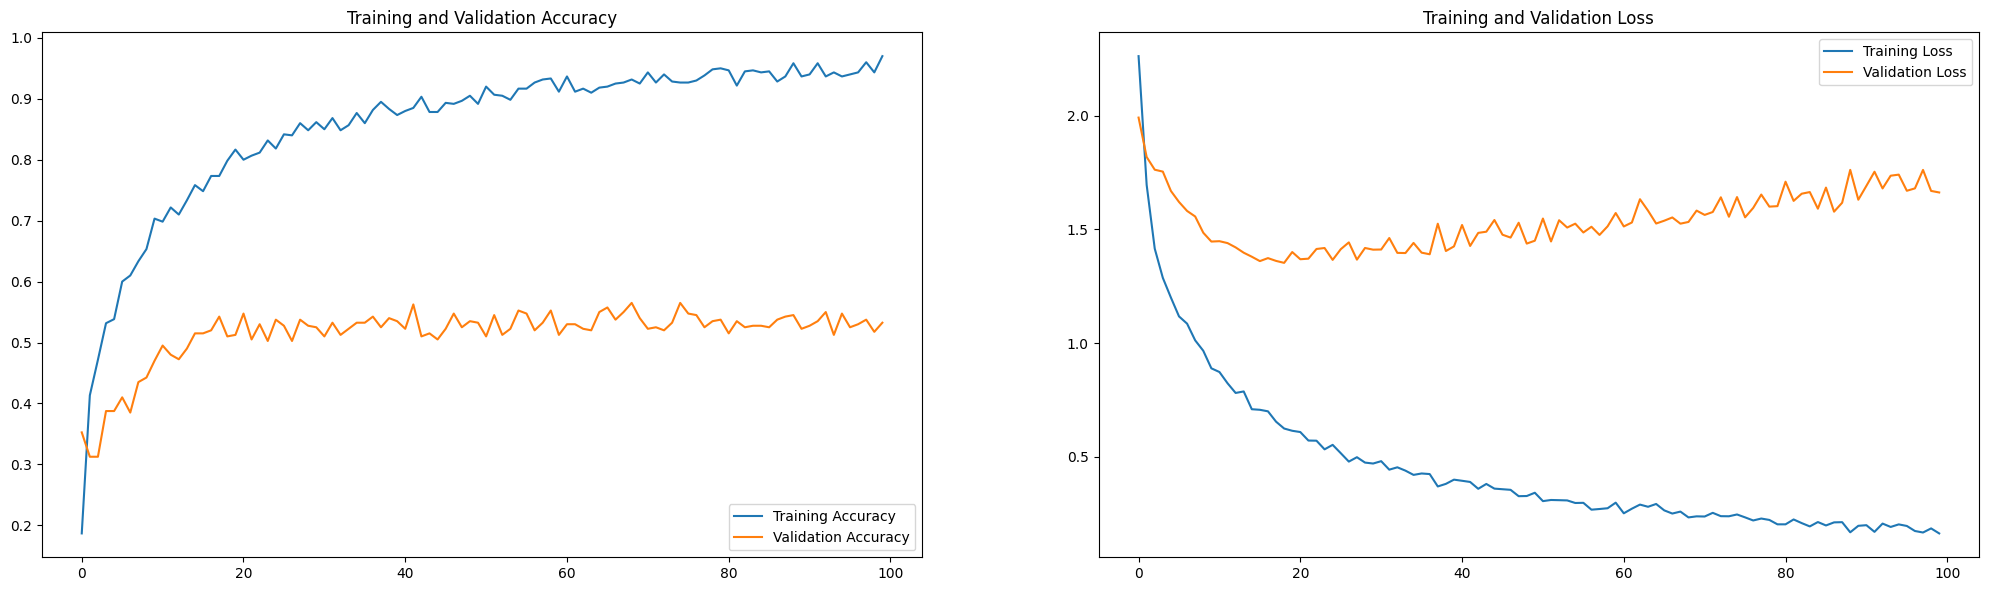

13/13 [==============================] - 8s 531ms/step
              precision    recall  f1-score   support

       blues       0.41      0.65      0.50        40
   classical       0.94      0.82      0.88        40
     country       0.37      0.47      0.42        40
       disco       0.45      0.42      0.44        40
      hiphop       0.48      0.57      0.52        40
        jazz       0.74      0.62      0.68        40
       metal       0.69      0.60      0.64        40
         pop       0.76      0.70      0.73        40
      reggae       0.33      0.33      0.33        40
        rock       0.28      0.12      0.17        40

    accuracy                           0.53       400
   macro avg       0.54      0.53      0.53       400
weighted avg       0.54      0.53      0.53       400



<Figure size 1500x600 with 0 Axes>

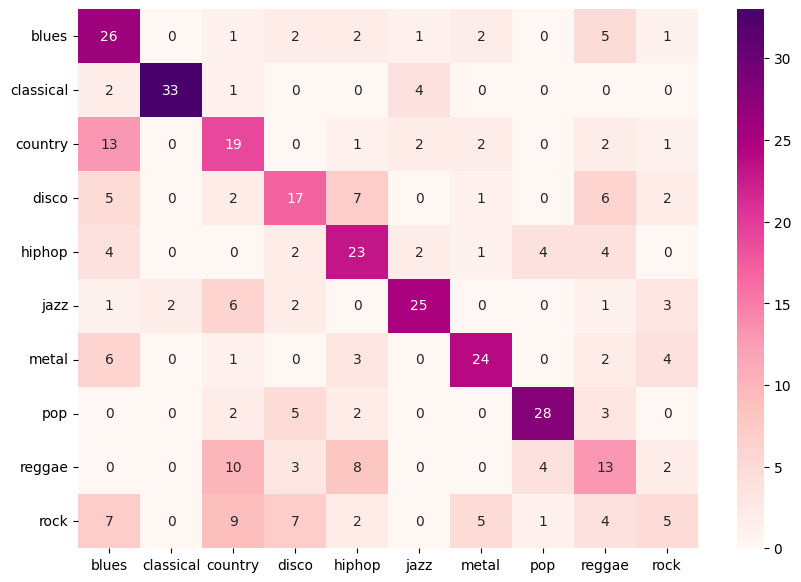

In [11]:
history20 = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=256, epochs=100)
import pickle
model.save_weights('100_epoch_tr_RNN2.cpkt')

pickle.dump(history20.history, open('history_100_epoch_tr_RNN2.pkl','wb'))
acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']
loss = history20.history['loss']
val_loss = history20.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_RNN2.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_RNN2_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx21.png',bbox_inches = 'tight')

## TL+100_GRU

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

Epoch 1/100
19/19 - 23s - loss: 1.8361 - accuracy: 0.3300 - val_loss: 1.8863 - val_accuracy: 0.3275 - 23s/epoch - 1s/step
Epoch 2/100
19/19 - 17s - loss: 1.2563 - accuracy: 0.5450 - val_loss: 1.6286 - val_accuracy: 0.3800 - 17s/epoch - 896ms/step
Epoch 3/100
19/19 - 18s - loss: 1.0194 - accuracy: 0.6217 - val_loss: 1.5333 - val_accuracy: 0.4350 - 18s/epoch - 945ms/step
Epoch 4/100
19/19 - 23s - loss: 0.9001 - accuracy: 0.6883 - val_loss: 1.4937 - val_accuracy: 0.4600 - 23s/epoch - 1s/step
Epoch 5/100
19/19 - 20s - loss: 0.7423 - accuracy: 0.7250 - val_loss: 1.4120 - val_accuracy: 0.4900 - 20s/epoch - 1s/step
Epoch 6/100
19/19 - 20s - loss: 0.7073 - accuracy: 0.7550 - val_loss: 1.4092 - val_accuracy: 0.5100 - 20s/epoch - 1s/step
Epoch 7/100
19/19 - 20s - loss: 0.6131 - accuracy: 0.7917 - val_loss: 1.4478 - val_accuracy: 0.4850 - 20s/epoch - 1s/step
Epoch 8/100
19/19 - 21s - loss: 0.5967 - accuracy: 0.7883 - val_loss: 1.7055 - val_accuracy: 0.4600 - 21s/epoch - 1s/step
Epoch 9/100
19/19 

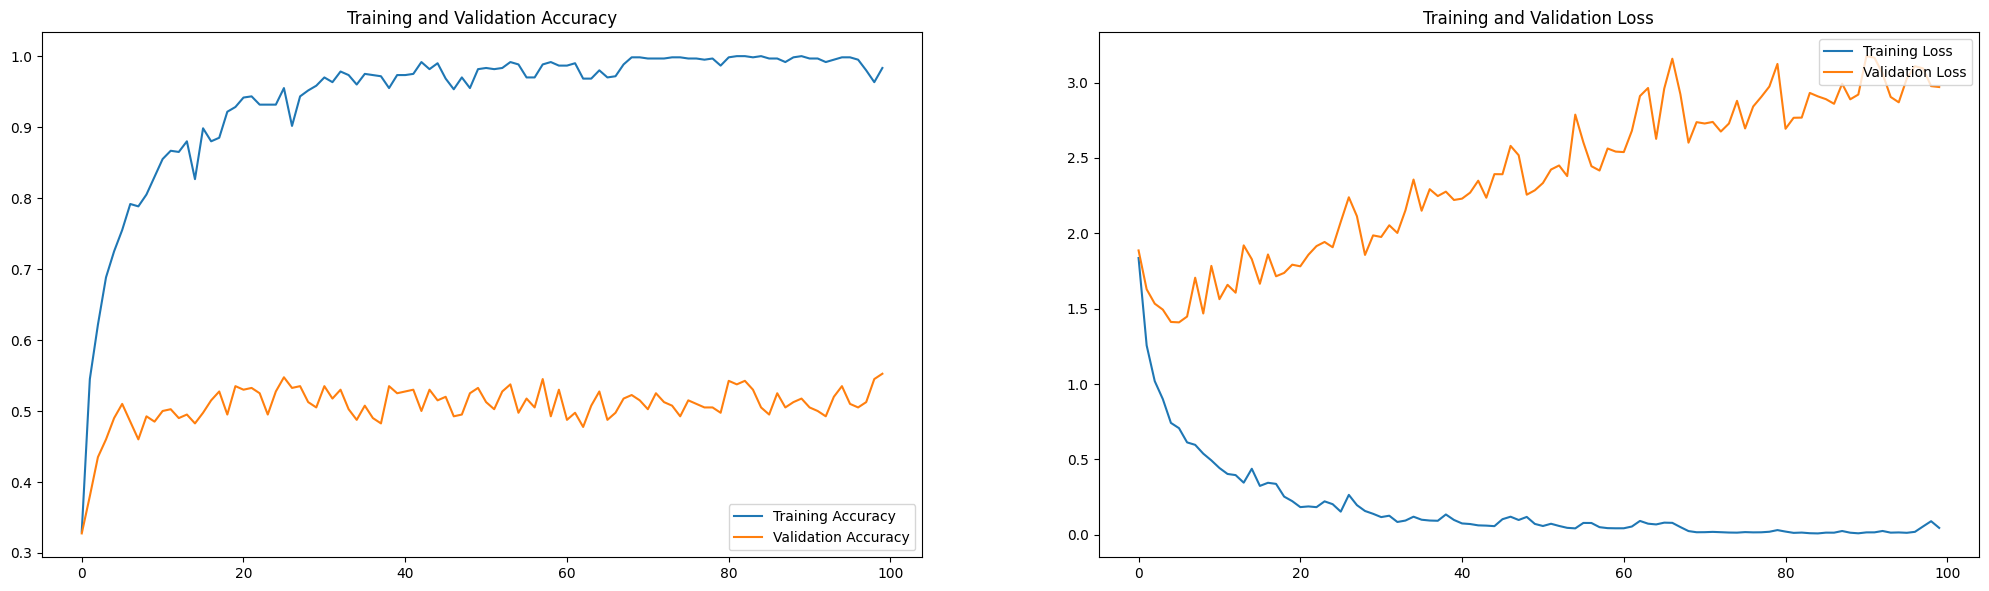

13/13 [==============================] - 8s 502ms/step
              precision    recall  f1-score   support

       blues       0.48      0.57      0.52        40
   classical       0.88      0.88      0.88        40
     country       0.51      0.47      0.49        40
       disco       0.45      0.57      0.51        40
      hiphop       0.42      0.78      0.54        40
        jazz       0.73      0.60      0.66        40
       metal       0.62      0.72      0.67        40
         pop       0.67      0.65      0.66        40
      reggae       0.48      0.25      0.33        40
        rock       0.10      0.03      0.04        40

    accuracy                           0.55       400
   macro avg       0.53      0.55      0.53       400
weighted avg       0.53      0.55      0.53       400



<Figure size 1500x600 with 0 Axes>

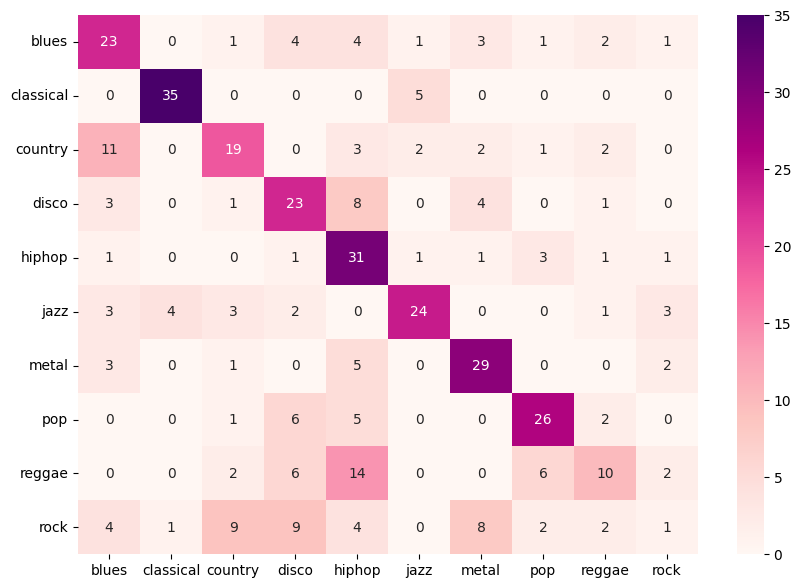

In [11]:
history17=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100,verbose=2)
import pickle
model.save_weights('100_epoch_tr_GRU.cpkt')

pickle.dump(history17.history, open('history_100_epoch_tr_GRU.pkl','wb'))
acc = history17.history['accuracy']
val_acc = history17.history['val_accuracy']
loss = history17.history['loss']
val_loss = history17.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx18.png',bbox_inches = 'tight')

## TL+100_GRU2(多加batch_size=256)

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

Epoch 1/100
3/3 - 25s - loss: 2.2387 - accuracy: 0.1800 - val_loss: 1.9688 - val_accuracy: 0.3075 - 25s/epoch - 8s/step
Epoch 2/100
3/3 - 17s - loss: 1.6505 - accuracy: 0.4417 - val_loss: 1.7767 - val_accuracy: 0.3675 - 17s/epoch - 6s/step
Epoch 3/100
3/3 - 14s - loss: 1.3419 - accuracy: 0.5333 - val_loss: 1.7753 - val_accuracy: 0.2975 - 14s/epoch - 5s/step
Epoch 4/100
3/3 - 14s - loss: 1.2621 - accuracy: 0.5417 - val_loss: 1.7464 - val_accuracy: 0.3650 - 14s/epoch - 5s/step
Epoch 5/100
3/3 - 14s - loss: 1.1572 - accuracy: 0.5833 - val_loss: 1.6089 - val_accuracy: 0.3825 - 14s/epoch - 5s/step
Epoch 6/100
3/3 - 15s - loss: 1.0506 - accuracy: 0.6117 - val_loss: 1.5842 - val_accuracy: 0.4150 - 15s/epoch - 5s/step
Epoch 7/100
3/3 - 16s - loss: 1.0055 - accuracy: 0.6450 - val_loss: 1.5178 - val_accuracy: 0.4200 - 16s/epoch - 5s/step
Epoch 8/100
3/3 - 15s - loss: 0.9156 - accuracy: 0.6750 - val_loss: 1.5253 - val_accuracy: 0.4500 - 15s/epoch - 5s/step
Epoch 9/100
3/3 - 15s - loss: 0.8709 - a

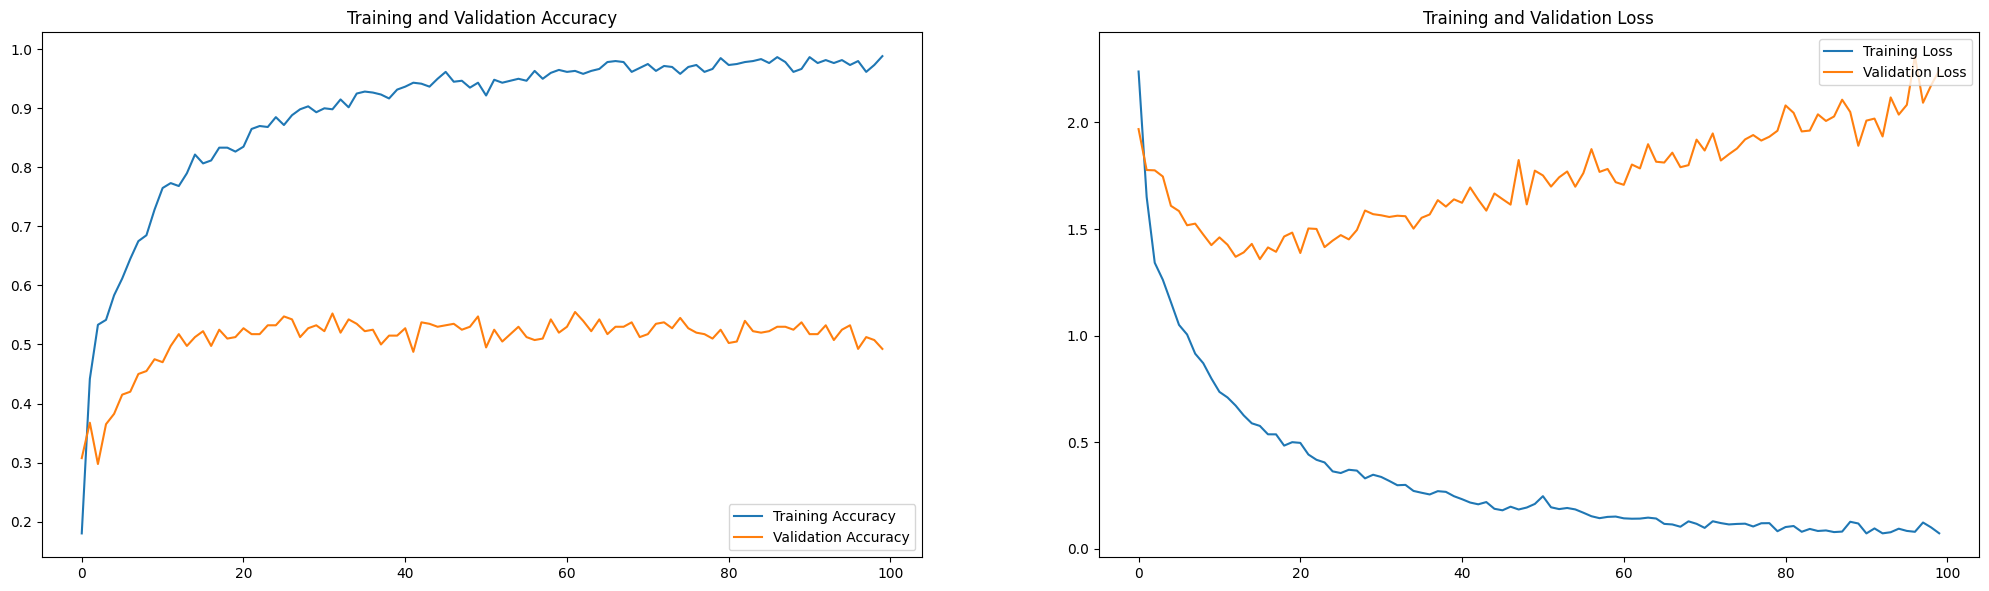

13/13 [==============================] - 8s 498ms/step
              precision    recall  f1-score   support

       blues       0.41      0.55      0.47        40
   classical       0.83      0.85      0.84        40
     country       0.41      0.38      0.39        40
       disco       0.50      0.40      0.44        40
      hiphop       0.33      0.80      0.47        40
        jazz       0.79      0.57      0.67        40
       metal       0.67      0.45      0.54        40
         pop       0.85      0.55      0.67        40
      reggae       0.28      0.23      0.25        40
        rock       0.24      0.15      0.18        40

    accuracy                           0.49       400
   macro avg       0.53      0.49      0.49       400
weighted avg       0.53      0.49      0.49       400



<Figure size 1500x600 with 0 Axes>

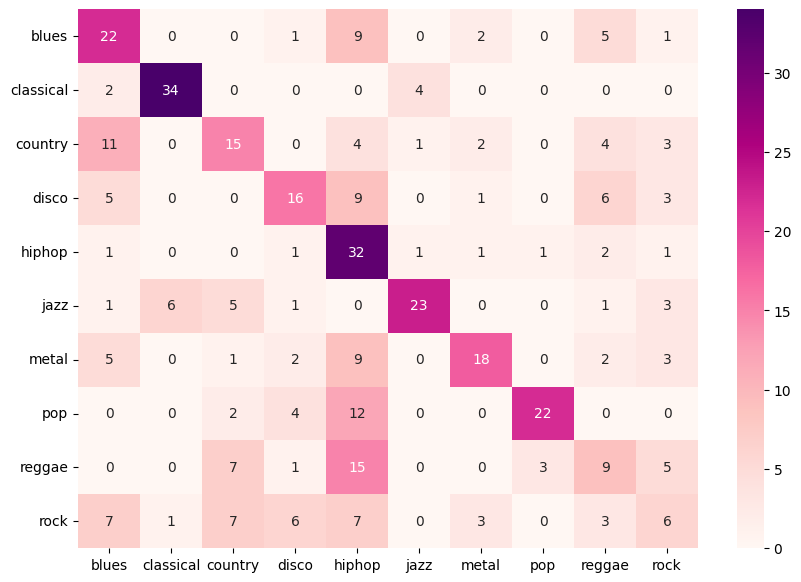

In [11]:
history21=model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=256, epochs=100, verbose=2)
import pickle
model.save_weights('100_epoch_tr_GRU3.cpkt')

pickle.dump(history21.history, open('history_100_epoch_tr_GRU3.pkl','wb'))
acc = history21.history['accuracy']
val_acc = history21.history['val_accuracy']
loss = history21.history['loss']
val_loss = history21.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU3.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU3_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx22.png',bbox_inches = 'tight')

In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold


mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
# 修改 GRU 層
gru_layer = Bidirectional(GRU(512, return_sequences=True, dropout=0.7, recurrent_dropout=0.7))(gru_input)
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
# 編譯模型，增加AUC-ROC分數
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

In [11]:
history17=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100,verbose=2)


Epoch 1/100
19/19 - 29s - loss: 2.3992 - accuracy: 0.1150 - auc: 0.4954 - val_loss: 2.3205 - val_accuracy: 0.1025 - val_auc: 0.5006 - 29s/epoch - 2s/step
Epoch 2/100
19/19 - 21s - loss: 2.3392 - accuracy: 0.1150 - auc: 0.5355 - val_loss: 2.2878 - val_accuracy: 0.1350 - val_auc: 0.5472 - 21s/epoch - 1s/step
Epoch 3/100
19/19 - 21s - loss: 2.3142 - accuracy: 0.1400 - auc: 0.5585 - val_loss: 2.2596 - val_accuracy: 0.1775 - val_auc: 0.5943 - 21s/epoch - 1s/step
Epoch 4/100
19/19 - 20s - loss: 2.3338 - accuracy: 0.1150 - auc: 0.5386 - val_loss: 2.2320 - val_accuracy: 0.2175 - val_auc: 0.6454 - 20s/epoch - 1s/step
Epoch 5/100
19/19 - 20s - loss: 2.2535 - accuracy: 0.1533 - auc: 0.5987 - val_loss: 2.2066 - val_accuracy: 0.2425 - val_auc: 0.6838 - 20s/epoch - 1s/step
Epoch 6/100
19/19 - 19s - loss: 2.2317 - accuracy: 0.1717 - auc: 0.6167 - val_loss: 2.1830 - val_accuracy: 0.2550 - val_auc: 0.7103 - 19s/epoch - 1s/step
Epoch 7/100
19/19 - 20s - loss: 2.2062 - accuracy: 0.1850 - auc: 0.6362 - va

FileNotFoundError: [Errno 2] No such file or directory: 'history_100_epoch_tr_GRU(11/11).pkl'

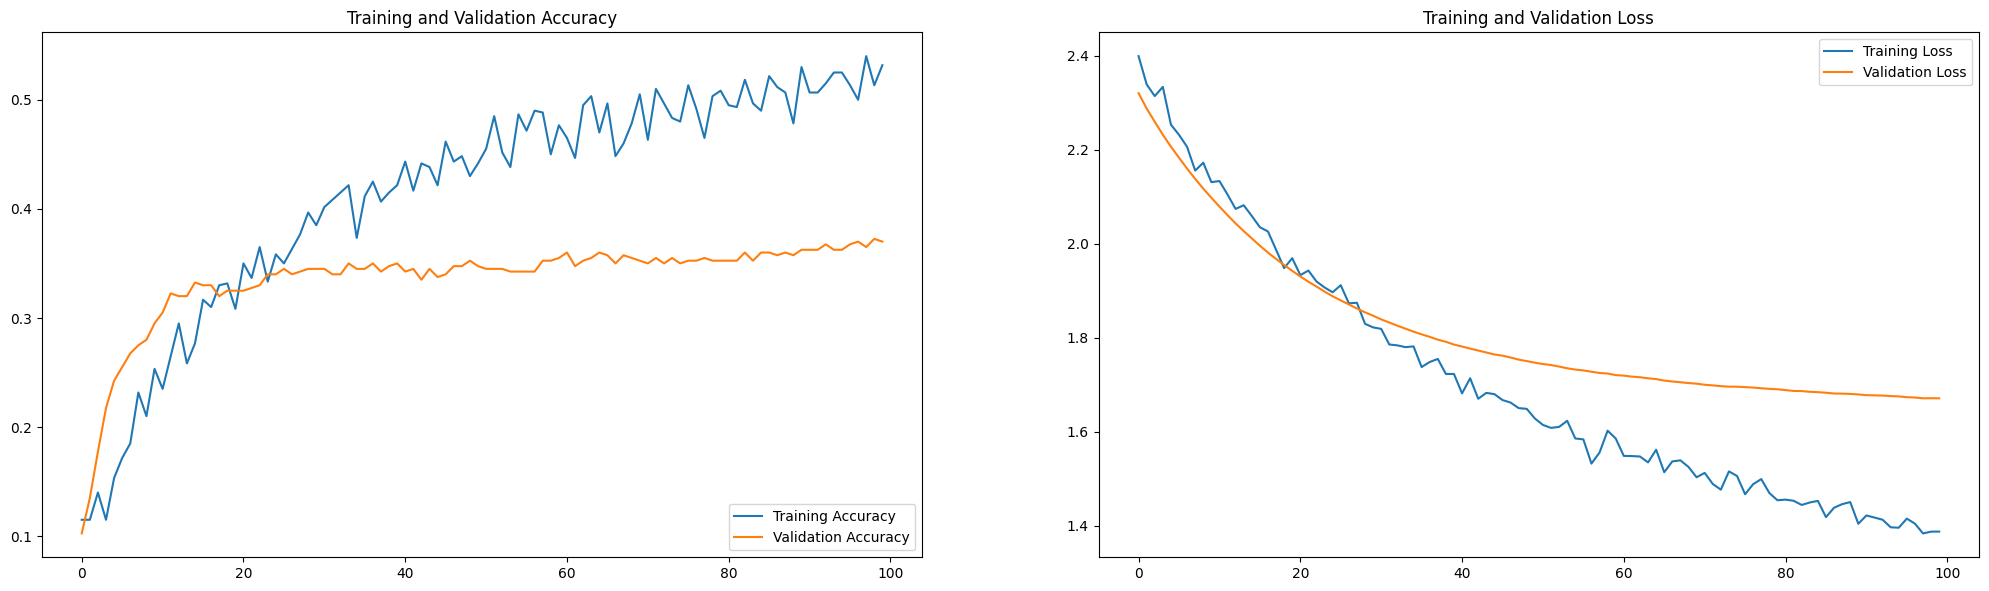

13/13 [==============================] - 9s 588ms/step
              precision    recall  f1-score   support

       blues       0.22      0.23      0.22        40
   classical       0.83      0.85      0.84        40
     country       0.00      0.00      0.00        40
       disco       0.17      0.10      0.13        40
      hiphop       0.38      0.55      0.45        40
        jazz       0.47      0.38      0.42        40
       metal       0.45      0.75      0.56        40
         pop       0.69      0.45      0.55        40
      reggae       0.14      0.17      0.16        40
        rock       0.25      0.23      0.24        40

    accuracy                           0.37       400
   macro avg       0.36      0.37      0.36       400
weighted avg       0.36      0.37      0.36       400



<Figure size 1500x600 with 0 Axes>

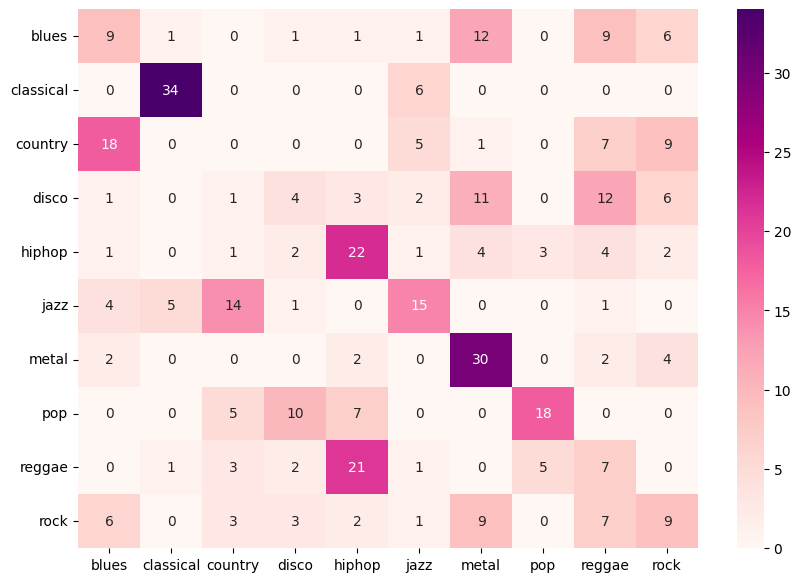

In [13]:
import pickle
model.save_weights('100_epoch_tr_GRU5.cpkt')

pickle.dump(history17.history, open('history_100_epoch_tr_GRU5.pkl','wb'))
acc = history17.history['accuracy']
val_acc = history17.history['val_accuracy']
loss = history17.history['loss']
val_loss = history17.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
import pickle
history = pickle.load(open('history_100_epoch_tr_GRU5.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_100_GRU5_plot1.png',bbox_inches = 'tight')
plt.clf()
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx25.png',bbox_inches = 'tight')

13/13 [==============================] - 8s 584ms/step


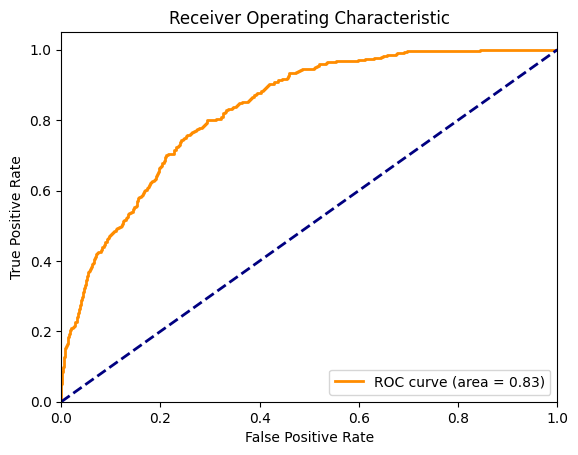

In [15]:
# 导入绘制 ROC 曲线所需的库
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 训练结束后，使用验证集进行预测
y_val_pred = model.predict(x_val)

# 计算 ROC 曲线所需的值
fpr, tpr, thresholds = roc_curve(y_val.ravel(), y_val_pred.ravel())
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
lw = 2  # 线宽
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## TL+100_GRU加入交叉驗證


In [10]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold


mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
mobilenetv2.trainable = False
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
# 修改 GRU 層
gru_layer = Bidirectional(GRU(512, return_sequences=True, dropout=0.7, recurrent_dropout=0.7))(gru_input)
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# 定義函數，用於訓練和評估模型
# def train_and_evaluate_model(model, x_train, y_train, x_val, y_val):
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# 使用十折交叉驗證
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 初始化列表，用於存儲每次交叉驗證的準確度
test_accuracies = []
all_histories = []
# 在交叉验证之前初始化列表来收集预测和真实标签
all_predictions = []
all_true_labels = []
for train_index, test_index in skf.split(x_train, y_train.argmax(axis=1)):
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
# 切分驗證集
    x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(
        x_train_fold, y_train_fold, test_size=0.1, stratify=y_train_fold, random_state=42
    )
    # 訓練模型
    history17=model.fit(x_train_fold, y_train_fold,validation_data=(x_val_fold, y_val_fold), epochs=100, verbose=2)
    #history17=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100,verbose=2)

    # 在測試集上進行預測
    predictions_fold = model.predict(x_test_fold)
    predictions_fold = np.argmax(predictions_fold, axis=1)

    # 計算準確度並存儲
    accuracy_fold = accuracy_score(np.argmax(y_test_fold, axis=1), predictions_fold)
    test_accuracies.append(accuracy_fold)
    all_histories.append(history17.history)
        # 预测当前折叠的测试集
    predictions_fold = model.predict(x_test_fold)
    predicted_labels_fold = np.argmax(predictions_fold, axis=1)
    true_labels_fold = np.argmax(y_test_fold, axis=1)

    # 累积预测和真实标签
    all_predictions.extend(predicted_labels_fold)
    all_true_labels.extend(true_labels_fold)
# 計算十次交叉驗證的平均準確度
final_test_accuracy = np.mean(test_accuracies)

# 在完整驗證集上進行評估
val_metrics = model.evaluate(x_val, y_val, verbose=0)
# 确保收集了所有折叠的预测和真实标签
assert len(all_predictions) == len(all_true_labels), "The number of predictions and true labels do not match."

print("Final Test Accuracy (10-fold cross-validation):", final_test_accuracy)
print("Validation Accuracy on Full Dataset:", val_metrics[1])
print("Validation AUC on Full Dataset:", val_metrics[2])

# 調用函數進行模型訓練和評估
# train_and_evaluate_model(model, x_train, y_train, x_val, y_val)


Epoch 1/100
16/16 - 14s - loss: 2.4000 - accuracy: 0.1132 - auc: 0.4978 - val_loss: 2.2710 - val_accuracy: 0.1111 - val_auc: 0.5741 - 14s/epoch - 857ms/step
Epoch 2/100
16/16 - 8s - loss: 2.3680 - accuracy: 0.0823 - auc: 0.5172 - val_loss: 2.2398 - val_accuracy: 0.0926 - val_auc: 0.6365 - 8s/epoch - 496ms/step
Epoch 3/100
16/16 - 8s - loss: 2.3246 - accuracy: 0.1543 - auc: 0.5462 - val_loss: 2.2119 - val_accuracy: 0.2222 - val_auc: 0.6887 - 8s/epoch - 488ms/step
Epoch 4/100
16/16 - 8s - loss: 2.3038 - accuracy: 0.1132 - auc: 0.5569 - val_loss: 2.1852 - val_accuracy: 0.3148 - val_auc: 0.7307 - 8s/epoch - 506ms/step
Epoch 5/100
16/16 - 8s - loss: 2.3000 - accuracy: 0.1296 - auc: 0.5626 - val_loss: 2.1600 - val_accuracy: 0.3148 - val_auc: 0.7620 - 8s/epoch - 509ms/step
Epoch 6/100
16/16 - 8s - loss: 2.2839 - accuracy: 0.1358 - auc: 0.5778 - val_loss: 2.1359 - val_accuracy: 0.3333 - val_auc: 0.7904 - 8s/epoch - 477ms/step
Epoch 7/100
16/16 - 8s - loss: 2.2409 - accuracy: 0.1955 - auc: 0.60

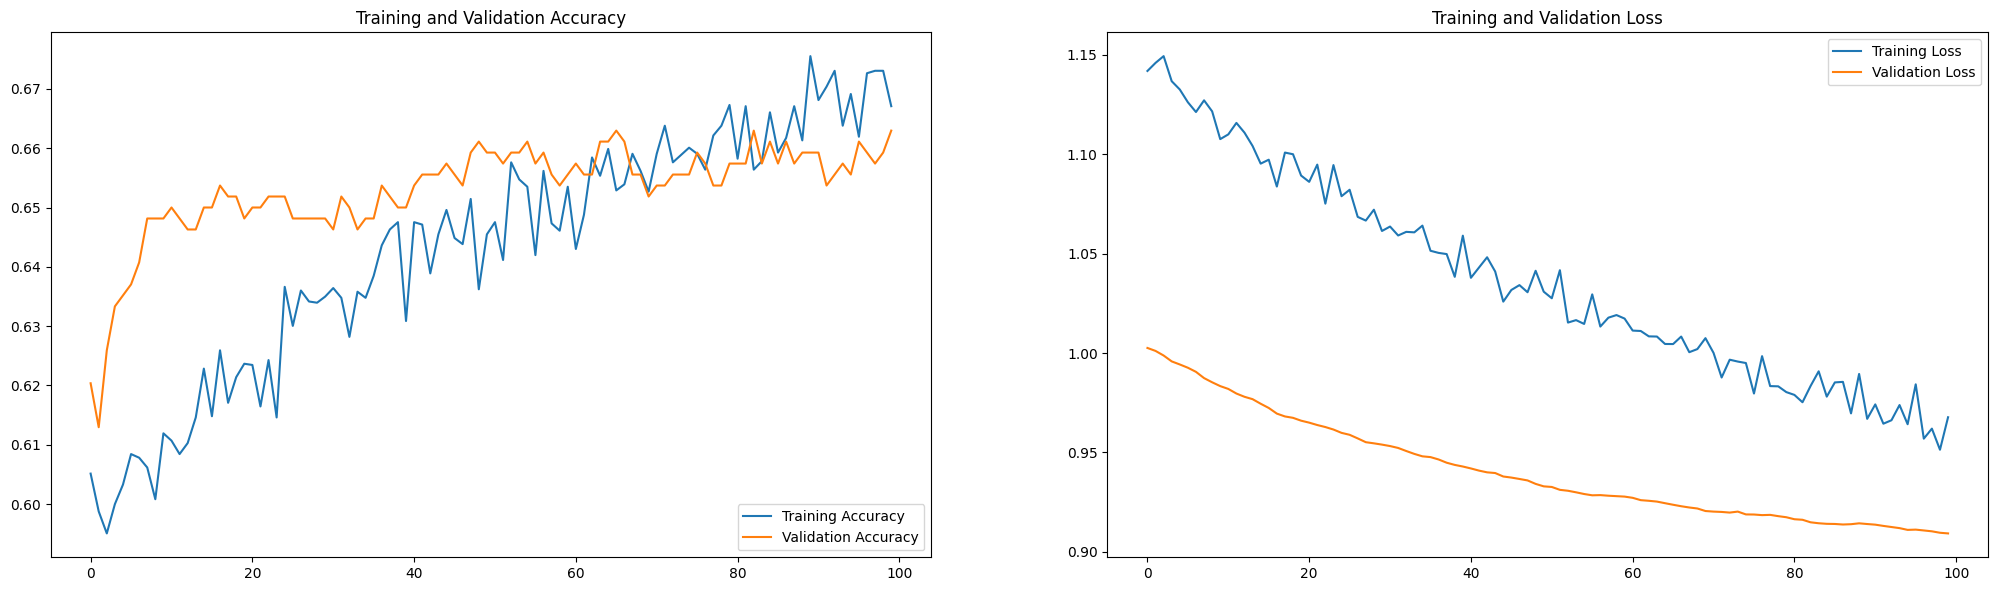

In [12]:
import pickle
model.save_weights('100_epoch_tr_GRU6.cpkt')
pickle.dump(all_histories, open('history_100_epoch_tr_GRU6.pkl','wb'))
# 交叉验证结束后，聚合历史数据并计算平均准确度和损失
average_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
# 计算所有折叠的平均历史数据
for epoch in range(100):  # 假设 epoch 数为100
    epoch_acc = np.mean([h['accuracy'][epoch] for h in all_histories])
    epoch_val_acc = np.mean([h['val_accuracy'][epoch] for h in all_histories])
    epoch_loss = np.mean([h['loss'][epoch] for h in all_histories])
    epoch_val_loss = np.mean([h['val_loss'][epoch] for h in all_histories])
    average_history['accuracy'].append(epoch_acc)
    average_history['val_accuracy'].append(epoch_val_acc)
    average_history['loss'].append(epoch_loss)
    average_history['val_loss'].append(epoch_val_loss)
    
epochs_range = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, average_history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, average_history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, average_history['loss'], label='Training Loss')
plt.plot(epochs_range, average_history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

13/13 [==============================] - 6s 428ms/step
              precision    recall  f1-score   support

       blues       0.75      0.73      0.74        60
   classical       0.90      0.93      0.92        60
     country       0.67      0.68      0.68        60
       disco       0.55      0.57      0.56        60
      hiphop       0.71      0.68      0.69        60
        jazz       0.80      0.72      0.75        60
       metal       0.80      0.88      0.84        60
         pop       0.62      0.75      0.68        60
      reggae       0.66      0.72      0.69        60
        rock       0.61      0.42      0.50        60

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.70       600
weighted avg       0.71      0.71      0.70       600



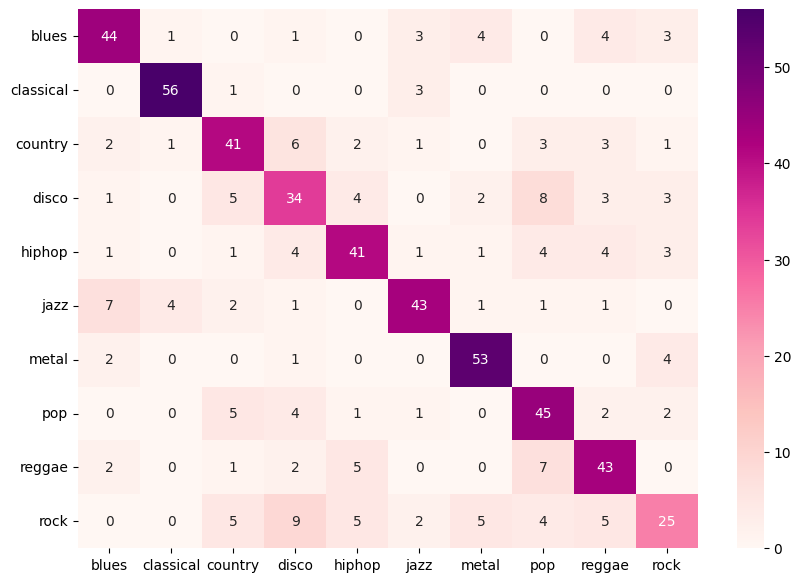

In [13]:
# import pickle
# all_histories = pickle.load(open('history_100_epoch_tr_GRU6.pkl','rb'))
# # 交叉验证结束后，聚合历史数据并计算平均准确度和损失
# average_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
# # 计算所有折叠的平均历史数据
# for epoch in range(100):  # 假设 epoch 数为100
#     epoch_acc = np.mean([h['accuracy'][epoch] for h in all_histories])
#     epoch_val_acc = np.mean([h['val_accuracy'][epoch] for h in all_histories])
#     epoch_loss = np.mean([h['loss'][epoch] for h in all_histories])
#     epoch_val_loss = np.mean([h['val_loss'][epoch] for h in all_histories])
#     average_history['accuracy'].append(epoch_acc)
#     average_history['val_accuracy'].append(epoch_val_acc)
#     average_history['loss'].append(epoch_loss)
#     average_history['val_loss'].append(epoch_val_loss)
    
# epochs_range = range(100)

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
# plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=10)
# ax1.plot(epochs_range, average_history['accuracy'], label='Training Accuracy', c = '#4CAF50', linewidth=4)
# ax1.plot(epochs_range, average_history['val_accuracy'], label='Validation Accuracy', c='red', linewidth=4)
# ax1.legend()
# ax1.set_title('Training and Validation Accuracy',fontsize=18)
# ax1.set_ylabel('Accuracy',fontsize=18)
# ax1.set_xlabel('Epoch',fontsize=18)

# ax2.plot(epochs_range, average_history['loss'], label='Training Loss',c = '#4CAF50', linewidth=4)
# ax2.plot(epochs_range, average_history['val_loss'], label='Validation Loss', c='red', linewidth=4)
# ax2.legend()
# ax2.set_title('Training and Validation Loss',fontsize=18)
# ax2.set_ylabel('Loss',fontsize=18)
# ax2.set_xlabel('Epoch',fontsize=18)
# fig.tight_layout(pad=3.0)
# #plt.show()
# plt.savefig('tfr_100_GRU6_plot1.png',bbox_inches = 'tight')
# plt.clf()

# 進行預測
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)
# 生成分类报告
# 基于所有折叠的预测和真实标签生成分类报告和混淆矩阵
final_report = classification_report(all_true_labels, all_predictions, target_names=labels)
print(final_report)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 生成混淆矩阵
final_cm = confusion_matrix(all_true_labels, all_predictions)
df_cm = pd.DataFrame(final_cm, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx16.png',bbox_inches = 'tight')



## 看結果+印出


In [20]:
# 檔案名稱和對應的模型類型
import pickle
import pandas as pd
file_names = ['history_500_epoch_tr.pkl', 'history_500_epoch_tr_BILSTM.pkl', 
              'history_500_epoch_tr_LSTM.pkl', 'history_500_epoch_tr_RNN.pkl', 
              'history_500_epoch_tr_GRU.pkl',
              'history_500_epoch_tr_BiLSTM2.pkl',
              'history_500_epoch_tr_LSTM2.pkl',
              'history_500_epoch_tr_RNN2.pkl',
              'history_500_epoch_tr_GRU2.pkl',
              'history_100_epoch_tr.pkl',
              'history_100_epoch_tr_BiLSTM.pkl',
              'history_100_epoch_tr_LSTM.pkl',
              'history_100_epoch_tr_RNN.pkl',
              'history_100_epoch_tr_GRU.pkl',
              'history_100_epoch_tr_BiLSTM2.pkl',
              'history_100_epoch_tr_LSTM2.pkl',
              'history_100_epoch_tr_RNN2.pkl',
              'history_100_epoch_tr_GRU3.pkl'
              ]
model_types = ['Transfer Learning', ' TL + BiLSTM', ' TL + LSTM', ' TL + RNN', ' TL + GRU',
               ' TL + BiLSTM2',' TL + LSTM2',' TL + RNN2',' TL + GRU2','100_TL',
               'TL + 100_BiLSTM','TL + 100_LSTM','TL + 100_RNN' ,'TL + 100_GRU',
               'TL + 100_BiLSTM2','TL + 100_LSTM2','TL + 100_RNN2' ,'TL + 100_GRU2']

avg_training_accs = []
avg_validation_accs = []

for file_name in file_names:
    history = pickle.load(open(file_name, 'rb'))
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # 將數據轉換為百分比形式
    acc_percentage = [round(a * 100, 2) for a in acc]
    val_acc_percentage = [round(va * 100, 2) for va in val_acc]
    
    # 計算平均值
    avg_training_accs.append(sum(acc_percentage) / len(acc_percentage))
    avg_validation_accs.append(sum(val_acc_percentage) / len(val_acc_percentage))

# 創建一個DataFrame來顯示結果
df_avg = pd.DataFrame({
    'Model Type': model_types,
    'Training Accuracy (%)': avg_training_accs, 
    'Validation Accuracy (%)': avg_validation_accs
})

# 顯示DataFrame
print(df_avg)

# 使用matplotlib繪製比較圖
plt.figure(figsize=(10, 5))
df_avg.set_index('Model Type').plot(kind='bar', ax=plt.gca())
plt.title('Average Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig('TL+ALL.png',bbox_inches = 'tight')
plt.clf()

           Model Type  Training Accuracy (%)  Validation Accuracy (%)
0   Transfer Learning               92.78326                  52.5395
1         TL + BiLSTM               98.70122                  51.1890
2           TL + LSTM               98.53156                  50.1900
3            TL + RNN               97.40274                  50.3510
4            TL + GRU               98.39696                  50.9845
5        TL + BiLSTM2               98.61064                  51.5150
6          TL + LSTM2               98.50134                  49.8775
7           TL + RNN2               97.40112                  50.2265
8           TL + GRU2               98.45186                  50.7700
9              100_TL               79.32340                  49.4275
10    TL + 100_BiLSTM               94.47130                  50.8950
11      TL + 100_LSTM               93.21990                  50.6925
12       TL + 100_RNN               90.09330                  50.7475
13       TL + 100_GR

<Figure size 1000x500 with 0 Axes>

In [13]:
epochs_range = range(500)
import matplotlib.pyplot as plt
import pickle 
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc1 = history['accuracy']
val_acc1 = history['val_accuracy']
loss1 = history['loss']
val_loss1 = history['val_loss']

history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc2 = history['accuracy']
val_acc2 = history['val_accuracy']
loss2 = history['loss']
val_loss2 = history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot(epochs_range, acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot(epochs_range, val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)
ax1.plot(epochs_range, acc2, label='Multi modal Training Accuracy', c = '#171c1c', linewidth=4)
ax1.plot(epochs_range, val_acc2, label='Multi modal Validation Accuracy', c='#62176e', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot(epochs_range, loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot(epochs_range, val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)
ax2.plot(epochs_range, loss2, label='Multi modal Training Loss',c = '#171c1c', linewidth=4)
ax2.plot(epochs_range, val_loss2, label='Multi modal learning Validation Loss', c='#62176e', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('all_2.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>